## Used Packages

In [1]:
# load packages
pkgs <- c("tidyverse", "ggsci", "cowplot",  "ggsignif", 
          "scales", "ggrepel", "UpSetR", "ggsankey", 
          "ggbreak", "ggbrace", "agricolae")
for (pkg in pkgs){
    suppressMessages(require(pkg, character.only = TRUE))
}

## Summary Table
- This table contains the general information of all NLR genes identifed in rice pan-NLRome.
- For the figures requiring extra data, corresponding dataset(s) will be imported in their coding cells.
- The path to data is: `/Share/home/qitiancong/00.project/01.panNLRome_v7/06.MS_v8_final_data/`. Anyone who want to test the code need to change the path with their own path.

In [2]:
# input summary table
data_path <- "/Share/home/qitiancong/00.project/01.panNLRome_v7/06.MS_v8_final_data/"
df <- read.csv(paste0(data_path, "SummaryTable_1May2022.csv"),
               header=TRUE, stringsAsFactors=FALSE)

## Figures

### Figure 1
NLR genes identified from the 65 rice accessions.

#### A

In [3]:
# generate input data
# genotype info
df_info <- read.table(paste0(data_path, "rice_NG2019_metadata.tab.origin"),
                   sep="\t", header=TRUE,
                   as.is=T,
                   check.names=F)

# specify wild accession info
df_wild <- read.csv(paste0(data_path, "rice_Nature2012_TableS2_wild_info.csv"),
                    sep=",", header=TRUE)

wild_acc <- df_info[df_info$Status == "Wild rice",]$Assembly_ID
wild_acc2 <- lapply(strsplit(wild_acc, split="-") , function(x){x[1]}) %>% unlist()

tmp <- data.frame(Assembly_ID=wild_acc, Accession.ID=wild_acc2) %>% 
    merge(df_wild, by='Accession.ID', all.x=TRUE) %>% 
    subset(, select=c('Assembly_ID', 'Ecotype')) %>% 
    mutate(Ecotype=str_replace(Ecotype, "Or", ""))

tmp2 <- df_info[c('Assembly_ID', 'Species')] %>% 
    merge(tmp, by='Assembly_ID', all.x=TRUE) %>% 
    mutate(Ecotype=replace_na(Ecotype,"")) %>% 
    mutate(Species2=paste0(Species, Ecotype))

df_info <- df_info %>% merge(tmp2[c('Assembly_ID', 'Species2')], by='Assembly_ID', all.x=TRUE)

# input snp matrix
data <- read.table(paste0(data_path, "SNP.subset20k.matrix"), 
                   sep="\t", skip=1,
                   as.is=T,
                   check.names=F)

# add colnames,as the raw table's colname line append an tab
txt <- readLines(paste0(data_path, "SNP.subset20k.matrix"))
col_names <- strsplit(txt[1], split="\t")[[1]]
colnames(data) <- col_names

# tidy up
data <- data[,7:72]
# remove two accessions with gene flow
data <- subset(data, select = -c(W0128, `W3105-1`))
# add Nipponbare back
data$Nipponbare <- "R"

In [4]:
# convert R -> 0; X->1; other allele -> 2
converted_list <- list()
for (i in 1:nrow(data)){
    converted_vec <- c()
    for (y in data[i,]){
        if (y=="R"){converted_vec <- append(converted_vec, 0)}
        else if (y=="X"){converted_vec <- append(converted_vec, 1)}
        else {converted_vec <- append(converted_vec, 2)}
    }
    converted_list[[i]] <- converted_vec
}

num_matrix <- as.data.frame(do.call(rbind, converted_list))
colnames(num_matrix) <- colnames(data)

# PCA main step
pcaS <- prcomp(t(num_matrix),center = T)

# calculate the fration of variance explained by each component
perc <- round(100*(pcaS$sdev^2 / sum(pcaS$sdev^2))[1:10],2)
names(perc) <- apply(array(seq(1,10,1)), 1, function(x){paste0("PC", x)})



# add population info on
pca_matrix  <- pcaS$x %>% merge(df_info[c('Assembly_ID', 'Status', 'Species2')], 
                                 by.x="row.names", 
                                 by.y="Assembly_ID", 
                                 all.x=TRUE)
# factor status
pca_matrix$Status <- factor(pca_matrix$Status, 
                            levels=c("Wild rice", "Landrace", "Modern cultivar"), 
                            labels=c("Wild", "Landrace", "Cultivar"))

# number of effective SNPs
print(paste("Number of effective SNPs:", nrow(num_matrix)))
# principle component importance
perc

[1] "Number of effective SNPs: 20199"


PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8   PC9  PC10 
25.99  7.09  4.75  3.03  2.95  2.35  2.15  1.89  1.85  1.77

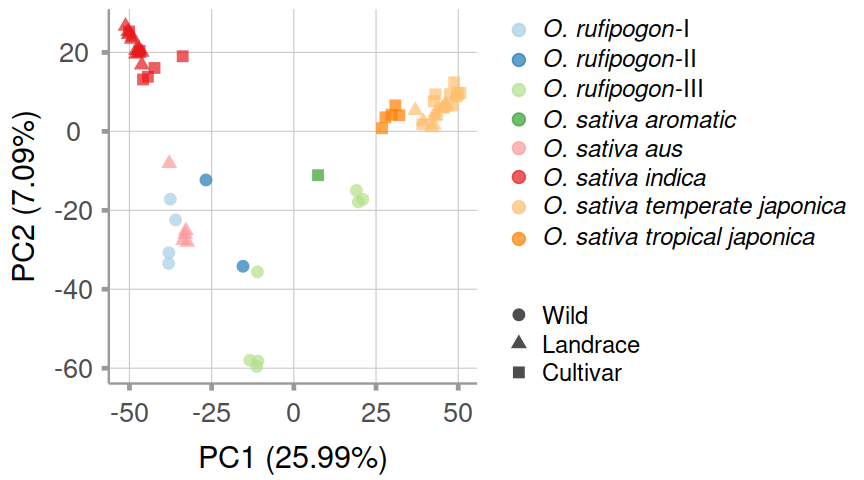

In [5]:
# plot section: species classification 
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_line(colour = "gray80", size = rel(0.5)), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              complete = TRUE,
              axis.text.x = element_text(size=16, color="gray30", margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_text(size=18, angle=0, margin = margin(t = 10, r = 0, b = 0, l = 0)),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 10, b = 0, l = 0)),
              legend.title = element_blank(),
#               legend.position = c(0.85,0.85),
              legend.position = "right",
              legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0,
              legend.background = element_rect(fill = "transparent", colour = "transparent")
             )
}

colors <- RColorBrewer::brewer.pal(8, "Paired") 

options(repr.plot.width = 7.2, repr.plot.height = 4)
ggplot(data=pca_matrix,aes(x=PC1,y=PC2))+
  geom_point(aes(color=Species2, shape=Status), size=3, alpha=0.7)+
  scale_color_manual(values = colors,
                     labels=expression(paste(italic("O. rufipogon"), "-I"),
                                      paste(italic("O. rufipogon"), "-II"),
                                      paste(italic("O. rufipogon"), "-III"),
                                      italic("O. sativa aromatic"),
                                      italic("O. sativa aus"),
                                      italic("O. sativa indica"),
                                      italic("O. sativa temperate japonica"),
                                      italic("O. sativa tropical japonica")))+
  theme_bw()+
  labs(x=paste("PC1 (", perc[1], "%)", sep=""),
       y=paste("PC2 (", perc[2], "%)", sep=""))+
  theme_custom()

#### B

In [6]:
# generate input
input <- df[,c('gene_ID', 'Assembly_ID', 'Species2')] %>% 
    group_by(Species2, Assembly_ID) %>% 
    summarise_at(vars(gene_ID), list(length)) %>% 
#     merge(df[c('Assembly_ID', 'Status2')] %>% unique(), by="Assembly_ID", all.x=TRUE)
    merge(df[c('Assembly_ID', 'Status')] %>% unique(), by="Assembly_ID", all.x=TRUE)


input$Assembly_ID <- factor(input$Assembly_ID, levels = input[order(-input$gene_ID),]$Assembly_ID)
# input$Status2 <- factor(input$Status2, levels=c("Wild rice", "Domesticated rice"))
input$Status <- factor(input$Status, levels=c("Wild", "Landrace", "Cultivar"))

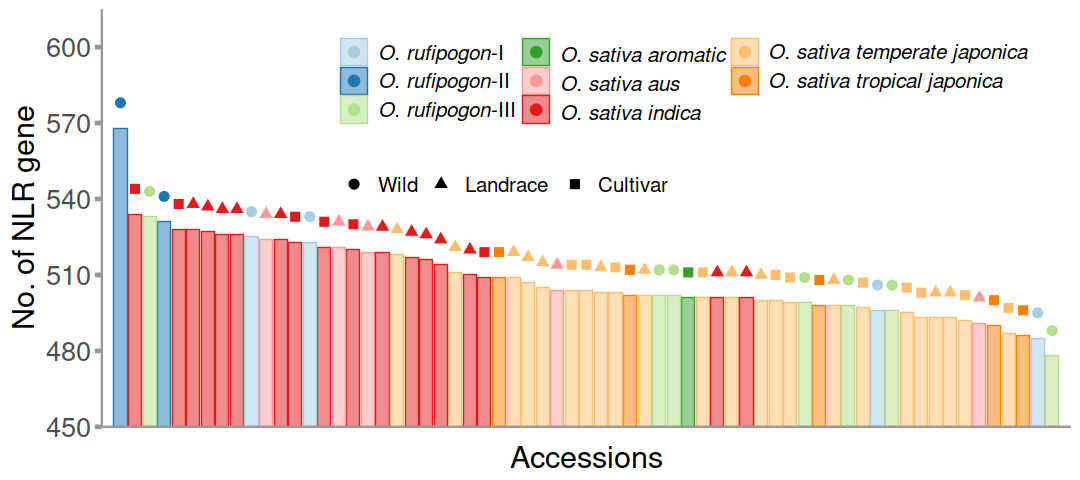

In [7]:
# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid = element_blank(),
              panel.background = element_rect(fill = "transparent",colour = NA),
              plot.background = element_rect(fill = "transparent",colour = NA),
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks.y = element_line(colour = "gray60", size = 1),
              axis.ticks.x = element_blank(),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              strip.text.x = element_blank(),
              complete = TRUE,
              axis.text.x = element_blank(),
              axis.text.y.left = element_text(size=16, 
                                         color="gray30",
                                         hjust=1, vjust = 0.5),
              axis.title.x = element_text(size=18, angle=0, color="black", margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.title.y = element_text(size=18, angle=90, color="black", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.6,0.75),
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 12),
              legend.text.align = 0,
              legend.background = element_rect(fill = "transparent",colour = NA)          
             )
}

options(repr.plot.width = 9, repr.plot.height = 4)
colors <- RColorBrewer::brewer.pal(8, "Paired") 
lab_txt <- expression(paste(italic("O. rufipogon"), "-I"),
                                      paste(italic("O. rufipogon"), "-II"),
                                      paste(italic("O. rufipogon"), "-III"),
                                      italic("O. sativa aromatic"),
                                      italic("O. sativa aus"),
                                      italic("O. sativa indica"),
                                      italic("O. sativa temperate japonica"),
                                      italic("O. sativa tropical japonica"))

p <- ggplot(input, aes(Assembly_ID, gene_ID, fill=Species2, color=Species2))
p + geom_col(alpha=0.5, width=0.9, size=0.3) +
    geom_point(aes(Assembly_ID, gene_ID+10, shape=Status), size=2.5) +
    theme_custom() +
    ylab("No. of NLR gene") +
    xlab("Accessions") +
    scale_y_continuous(expand = expansion(mult = c(0, 0.1)), 
                       n.breaks=6)+
    coord_cartesian(ylim = c(450, 600)) + 
    scale_x_discrete(expand = expansion(mult = c(0.02, 0.02)))+
    scale_color_manual(values = colors, labels=lab_txt) +
    scale_fill_manual(values = colors, labels=lab_txt) +
    guides(color = guide_legend(nrow = 3, label.position="right", label.vjust=0.3)) +
    guides(shape = guide_legend(nrow = 1, label.position="right"))

#### C

In [8]:
# all input
data_all <- df[,c('gene_ID', 'Assembly_ID', 'Status')] %>% group_by(Status, Assembly_ID) %>% 
            summarise_at(vars(gene_ID), list(length))
data_all$c_type = "All"

# clustered NLR
data_clu <- df[grepl("Concat", df$Clustered_Type),][,c('gene_ID', 'Assembly_ID', 'Status')] %>% 
    group_by(Status, Assembly_ID) %>% 
    summarise_at(vars(gene_ID), list(length))
data_clu$c_type = 'Clustered'

# paired NLR
data_pair <- df[df$Pair_partner_new != "-",][,c('gene_ID', 'Assembly_ID', 'Status')] %>% 
    group_by(Status, Assembly_ID) %>% 
    summarise_at(vars(gene_ID), list(length))
data_pair$c_type <- 'Paired' 

# entire input
data <- rbind(data_all, data_clu, data_pair)
data$Status <- factor(data$Status, levels=c("Wild", "Landrace", "Cultivar"))

# add significance annotation
sig_cl <- c()
sig_cw <- c()
sig_lw <- c()
status <- c("Cultivar", "Landrace", "Wild")
for (i in unique(data$c_type)){
    df_tmp <- data[(data$c_type == i),]
    # test btw cult and land
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[1]),]$gene_ID, 
                     df_tmp[(df_tmp$Status == status[2]),]$gene_ID)$p.value
    sig_cl <- append(sig_cl, pvalue)
    # test btw cult and wild
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[1]),]$gene_ID, 
                     df_tmp[(df_tmp$Status == status[3]),]$gene_ID)$p.value
    sig_cw <- append(sig_cw, pvalue)
    # test btw land and wild
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[2]),]$gene_ID, 
                     df_tmp[(df_tmp$Status == status[3]),]$gene_ID)$p.value
    sig_lw <- append(sig_lw, pvalue)
}

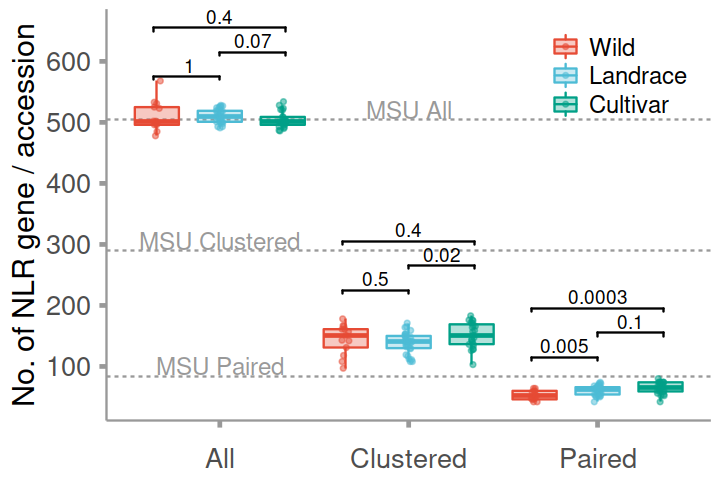

In [9]:
# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 10, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 5, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.85,0.85),
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0,
              legend.background = element_rect(fill = "transparent", colour = "transparent")
             )
}

# sig annotation position
sig_pos_y = c(575, 615, 655)
sig_pos_x_min = c(0.65,1,0.65)
sig_pos_x_max = c(1,1.35,1.35)

options(repr.plot.width = 6, repr.plot.height = 4)
p <- ggplot(data, aes(c_type, gene_ID, fill=Status, color=Status)) +
     geom_hline(yintercept=505, color='grey60', size =0.5, linetype = "dashed") +
     geom_hline(yintercept=290, color='grey60', size =0.5, linetype = "dashed") +
     geom_hline(yintercept=84, color='grey60', size =0.5, linetype = "dashed") +
     geom_boxplot(alpha=0.3, width=0.7, 
                  position = position_dodge(1),
                  outlier.colour="transparent") +
     geom_jitter(size=1,   
                 alpha=0.5,
                 position = position_jitterdodge(jitter.width=0.1, dodge.width=1)) + 
     ylab("No. of NLR gene / accession")+
     theme_custom() +
     scale_fill_npg() +
     scale_color_npg() +
     scale_y_continuous(n.breaks=6) +
     geom_signif(y_position=sig_pos_y, color='black',
                 xmin=sig_pos_x_min, 
                 xmax=sig_pos_x_max, 
                 tip_length=0.01,
                 annotation=formatC(c(sig_lw[1], sig_cl[1], sig_cw[1]), digits=1)) +
     geom_signif(y_position=sig_pos_y - 350, color='black',
                 xmin=sig_pos_x_min +1 , 
                 xmax=sig_pos_x_max +1 , 
                 tip_length=0.01,
                 annotation=formatC(c(sig_lw[2], sig_cl[2],  sig_cw[2]), digits=1)) +
     geom_signif(y_position=sig_pos_y - 460, color='black',
                 xmin=sig_pos_x_min +2 , 
                 xmax=sig_pos_x_max +2 , 
                 tip_length=0.01,
                 annotation=formatC(c(sig_lw[3], sig_cl[3],  sig_cw[3]), digits=1)) +
    annotate("text",x=2,y=520,label="MSU All",color="grey60",size=5) +
    annotate("text",x=1,y=305,label="MSU Clustered",color="grey60",size=5) +
    annotate("text",x=1,y=100,label="MSU Paired",color="grey60",size=5)
p

#### D

In [10]:
# generate input
# All NLR
data_all <- df[c('gene_ID', 'Assembly_ID', 'Species2')] %>% group_by(Species2, Assembly_ID) %>% 
            summarise_at(vars(gene_ID), list(length))
data_all$c_type = "All"

# clustered NLR
data_clu <- df[grepl("Concat", df$Clustered_Type),][,c('gene_ID', 'Assembly_ID', 'Species2')] %>% 
    group_by(Species2, Assembly_ID) %>% 
    summarise_at(vars(gene_ID), list(length))
data_clu$c_type = 'Clustered'

# paired NLR
data_pair <- df[df$Pair_partner_new != "-",][,c('gene_ID', 'Assembly_ID', 'Species2')] %>% 
    group_by(Species2, Assembly_ID) %>% 
    summarise_at(vars(gene_ID), list(length))
data_pair$c_type <- 'Paired' 

# entire input
data <- rbind(data_all, data_clu, data_pair)

In [11]:
# generate significance annotation
suppressMessages(require("agricolae"))
aov_sig <- function(data, Ctype, threshold=0.01){
    oneway <- aov(gene_ID~Species2, data=data[data$c_type==Ctype,])
    lsd_ad <- LSD.test(oneway, "Species2", p.adj="bonferroni", alpha=threshold)
    lsd_ad1 <- lsd_ad$groups
    lsd_ad2 <- data.frame(Species2 = row.names(lsd_ad1),
                          sig = lsd_ad1$groups)
    lsd_ad2 <- lsd_ad2[order(lsd_ad2$Species2),]
    lsd_ad2$c_type <- Ctype
    max_value <- data[data$c_type==Ctype,]  %>% group_by(Species2) %>% 
                    summarise_at(vars(gene_ID), list(max))
    lsd_ad2$max <- max_value$gene_ID
    return(lsd_ad2)
}

df_sig <- rbind(aov_sig(data, "All"), 
              aov_sig(data, "Clustered"), 
              aov_sig(data, "Paired"))

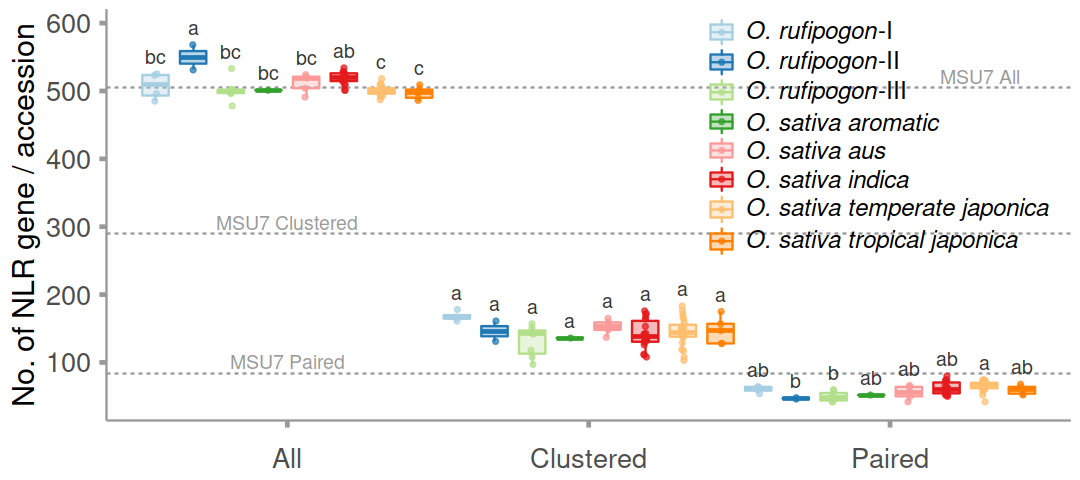

In [12]:
# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 10, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 5, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.8,0.7),
#               legend.position = "right",
#               legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0,
              legend.background = element_rect(fill = "transparent", colour = "transparent")
             )
}

colors <- RColorBrewer::brewer.pal(9, "Paired") 

options(repr.plot.width = 9, repr.plot.height = 4)
p <- ggplot(data, aes(c_type, gene_ID, fill=Species2, color=Species2)) +
     geom_hline(yintercept=505, color='grey60', size =0.5, linetype = "dashed") +
     geom_hline(yintercept=290, color='grey60', size =0.5, linetype = "dashed") +
     geom_hline(yintercept=84, color='grey60', size =0.5, linetype = "dashed") +
     geom_boxplot(alpha=0.3, width=0.7, size=0.5,
                  position = position_dodge(1),
                  outlier.colour="transparent") +
     geom_jitter(size=1,alpha=0.7,
                 position = position_jitterdodge(jitter.width=0.01, dodge.width=1)) + 
     geom_text(data=df_sig, aes(x=c_type, y=max+25, label=sig), 
               position = position_dodge(1),
               color="grey20", size=4)+
     ylab("No. of NLR gene / accession")+
     theme_custom() +
     scale_y_continuous(n.breaks=6) +
    scale_color_manual(values = colors,
                     labels=expression(paste(italic("O. rufipogon"), "-I"),
                                      paste(italic("O. rufipogon"), "-II"),
                                      paste(italic("O. rufipogon"), "-III"),
                                      italic("O. sativa aromatic"),
                                      italic("O. sativa aus"),
                                      italic("O. sativa indica"),
                                      italic("O. sativa temperate japonica"),
                                      italic("O. sativa tropical japonica"))) +
    scale_fill_manual(values=colors,
                     labels=expression(paste(italic("O. rufipogon"), "-I"),
                                      paste(italic("O. rufipogon"), "-II"),
                                      paste(italic("O. rufipogon"), "-III"),
                                      italic("O. sativa aromatic"),
                                      italic("O. sativa aus"),
                                      italic("O. sativa indica"),
                                      italic("O. sativa temperate japonica"),
                                      italic("O. sativa tropical japonica"))) +
    annotate("text",x=3.3,y=520,label="MSU7 All",color="grey60",size=4) +
    annotate("text",x=1,y=305,label="MSU7 Clustered",color="grey60",size=4) +
    annotate("text",x=1,y=100,label="MSU7 Paired",color="grey60",size=4)

p

### Figure 2
Overview of the rice pan-NLRome.

#### A

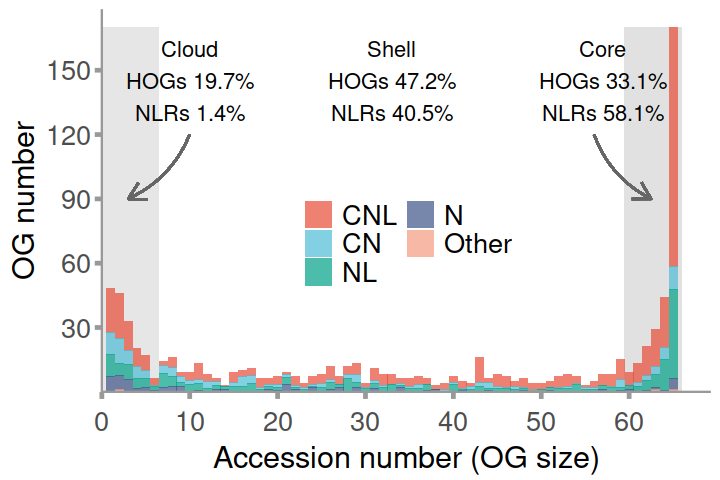

In [13]:
# generate the size of every OG
# calculate the proportion of every class in the HOG size
data1 <- df
data1$HOG_size <- NULL
data1 <- data1[!grepl("Miss", df$HOG),]
data1$NLR_class = gsub("X","", data1$New2_NLR_class)

HOG_size <- data1[,c("HOG", "Assembly_ID")] %>% 
    unique() %>% 
    group_by(HOG) %>% 
    summarise_at(vars(Assembly_ID), list(length))
colnames(HOG_size)[2] = "HOG_size"

data2 <- merge(data1, HOG_size, by= "HOG", all.x=TRUE )

HOG_szie_dtb <- HOG_size %>% 
    group_by(HOG_size) %>% summarise_at(vars(HOG), list(length))
colnames(HOG_szie_dtb)[2] = "HOG_number"

# function for frequency coulculation
hog_freq <- function(data2, arch, HOG_szie_dtb, cond){
    ratio_list <- c()
    for (i in c(1:65)){
        ratio <- data2[cond & (data2$HOG_size == i),]$gene_ID %>% length / 
            data2[(data2$HOG_size == i),]$gene_ID %>% length * 
            HOG_szie_dtb[HOG_szie_dtb$HOG_size==i,]$HOG_number
        ratio_list <- append(ratio_list, ratio)
    }
    df_out <- list("HOG_size"=c(1:65), "HOG_number"=ratio_list) %>% as.data.frame()
    df_out$NLR_class <- arch
    return(df_out)
}

HOG_CNL <- hog_freq(data2, "CNL", HOG_szie_dtb, (data2$NLR_class == "CNL"))
HOG_CN <- hog_freq(data2, "CN", HOG_szie_dtb, (data2$NLR_class == "CN"))
HOG_NL <- hog_freq(data2, "NL", HOG_szie_dtb, (data2$NLR_class == "NL"))
HOG_N <- hog_freq(data2, "N", HOG_szie_dtb, (data2$NLR_class == "N"))
HOG_other <- hog_freq(data2, "Other", HOG_szie_dtb, !(data2$NLR_class %in% c("CNL", "CN", "NL","N")))

# generate input data
data <- rbind(HOG_CNL,HOG_CN,HOG_NL,HOG_N,HOG_other)
data$NLR_class <- factor(data$NLR_class, levels = unique(data$NLR_class))

# calculate HOG number and NLR number for cloud/shell/core
core_hog <- HOG_size[HOG_size$HOG_size>=60, ]$HOG %>% length()
shell_hog <- HOG_size[(HOG_size$HOG_size>6)&(HOG_size$HOG_size<60), ]$HOG %>% length()
cloud_hog <- HOG_size[HOG_size$HOG_size<=6, ]$HOG %>% length()
total_hog <- HOG_size$HOG %>% length()

hog_ratio <- c(core_hog, shell_hog, cloud_hog) / total_hog

core_nlr <- data2[data2$HOG_size>=60,]$gene_ID %>% length()
shell_nlr <- data2[(data2$HOG_size>6) & (data2$HOG_size<60),]$gene_ID %>% length()
cloud_nlr <- data2[data2$HOG_size<=6,]$gene_ID %>% length()
total_nlr <- data2$gene_ID %>% length()

nlr_ratio <- c(core_nlr, shell_nlr, cloud_nlr) / total_nlr

# format to percentage
percent <- function(x, digits = 1, format = "f", ...) {
  paste0(formatC(100 * x, format = format, digits = digits, ...), "%")
}

hog_ratio <- percent(hog_ratio)
nlr_ratio <- percent(nlr_ratio)

# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid = element_blank(),
              panel.background = element_rect(fill = "transparent",colour = NA),
              plot.background = element_rect(fill = "transparent",colour = NA),
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              strip.text.x = element_blank(),
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.text.y.left = element_text(size=16, 
                                         color="gray30",
                                         hjust=1, vjust = 0.5),
              axis.title.x = element_text(size=18, angle=0, color="black", margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.title.y =  element_text(size=18, angle=90, color="black", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.5,0.4),
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 16),
              legend.text.align = 0
#               legend.key = element_rect(fill = "transparent",colour = NA)          
             )
}

options(repr.plot.width = 6, repr.plot.height = 4)
p2 <- ggplot(data, aes(fill = NLR_class,
                     y = HOG_number, 
                     x = HOG_size))+
        geom_rect(aes(xmin=59.5, xmax=66, ymin=0, ymax=170), alpha=0.05, fill="grey90") +
#         geom_rect(aes(xmin=6.5, xmax=59.5, ymin=0, ymax=170), alpha=0.1, fill="white") +
        geom_rect(aes(xmin=0, xmax=6.5, ymin=0, ymax=170), alpha=0.1, fill="grey90") +
        geom_bar(position = "stack", stat = "identity", alpha=0.7)+
        annotate(geom="text", x=c(10, 33, 57), y=160, label=c("Cloud","Shell","Core"), size=4.5, color="black") +
        annotate(geom="text", x=c(57, 33, 10), y=145, label=paste("HOGs",hog_ratio), size=4.5, color="black") +
        annotate(geom="text", x=c(57, 33, 10), y=130, label=paste("NLRs",nlr_ratio), size=4.5, color="black") +
        geom_curve(x=10, y=120, xend=3, yend=90, curvature = -0.2, color="grey40", arrow = arrow(length = unit(0.05, "npc"))) +
        geom_curve(x=56, y=120, xend=62.5, yend=90, curvature = 0.2, color="grey40", arrow = arrow(length = unit(0.05, "npc"))) +
        scale_y_continuous(expand = expansion(mult = c(0, 0.05)), breaks=c(30, 60, 90, 120, 150, 180))+
        scale_x_continuous(expand = expansion(mult = c(0, 0.05)), n.breaks=6)+
        theme_custom() +
        scale_fill_npg() +
        ylab("OG number") +
        xlab("Accession number (OG size)") +
        guides(fill=guide_legend(nrow=3))
p2

#### B

In [14]:
# generate input data
data <- df[c("HOG", "Assembly_ID","gene_ID")] %>% 
        group_by(Assembly_ID, HOG) %>% 
        summarise_at(vars(gene_ID), list(length)) %>% 
        spread(,key = "Assembly_ID",value = "gene_ID") %>% 
        column_to_rownames(var="HOG")
data[is.na(data)] = 0
data[data > 0] =1 # floor all non-zero cell to one 

# # create acc order
tmp <- df[c("Assembly_ID", "Species2")] %>% unique()
acc_order <- tmp[order(tmp$Species),]$Assembly_ID

# create row order
tmp2 <- data
tmp2$Sum <- rowSums(data)
row_order <- tmp2[order(-tmp2$Sum),] %>% rownames()

# decide the borders of pan-genome sections
tmp2 <- tmp2[order(-tmp2$Sum),]
core_shell_sep <- rownames(tmp2[tmp2$Sum < 60,])[1]
shell_cloud_sep <- rownames(tmp2[tmp2$Sum < 7,])[1]

In [15]:
# grouping accessions as subspecies
rufi1 <- c('W0123-1', 'W1754', 'W0170', 'W1698' )
rufi2 <- c('W1687', 'W1979')
rufi3 <- c('W0141', 'W2012', 'W1739', 'W1777', 'W3078-2', 'W1943', 'W3095-2')

indica <- c('GP3', 'GP22', 'GP72', 'GP51', 'HP119', 'GLA4', 'HP407', 
            'HP274', 'HP486', 'HP517-1', 'HP362-2', 'HP396', 'HP577', 
            'HP263', 'HP383','HP492','HP327','GP772-1')
aus <- c('GP62', 'Kasalath', 'GP104', 'GP124', 'GP540')
aromatic <- c('GP295-1')
trop_jap <- c('GP39', 'GP761-1', 'GP77', 'GP536', 'GP640')
temp_jap <- c('HP45', 'UR28', 'HP314', 'HP13-2', 'HP103', 'GP567', 'HP91-2', 'HP14',
              'HP38', 'HP48', 'HP44', 'GP677', 'KY131', 'LG31', 'DHX2', 'HP390', 'WYG7',
              'GP669', 'IL9', 'GP551', 'HP98', 'Koshihikari', 'Nipponbare')
acc_list <- list(rufi1, rufi2, rufi3, aromatic, aus, indica, temp_jap, trop_jap)

# allocate discrete number for subspecies
ind = 1
for (i in acc_list){
    for (y in i){
        data[data[y] == 1, ][y] = ind
    }
     ind = ind +1
}

# reshape input matrix
input <- data %>% rownames_to_column(var="HOG") %>% 
    gather(Assembly_ID, value, 'DHX2':'WYG7')

input$HOG <- factor(input$HOG, levels=rev(row_order))
input$Assembly_ID <- factor(input$Assembly_ID, levels=acc_order)

In [16]:
# known gene
hog <- c('HOG_037','HOG_039','HOG_102','HOG_155','HOG_156','HOG_174','HOG_207',
         'HOG_235','HOG_268','HOG_278','HOG_295','HOG_297','HOG_334',
         'HOG_377','HOG_389','HOG_391','HOG_392','HOG_403','HOG_429',
         'HOG_461','HOG_508','HOG_614','HOG_634','HOG_639','HOG_790','HOG_799')

kwn <- c('PiPR1','Xa1/Xo1','Pi63','PigmR','PigmS','Pib','Pit','Bph14','RGA5',
         'RGA4','Pi64','Pi37','Bph9','Pi54','Rpr1','Pik_1','NLS1',
         'Pi36','Pik_2','Pi_ta2','Pid3','Pi5_1','Pi_ta','Pi5_2','Pb1','Wed')


df_kwn <- data.frame(HOG=hog, kwn_nlr=kwn)
df_kwn$HOG <- str_replace(df_kwn$HOG, "HOG_", "N0.HOG0000")

table <- df_kwn %>% merge(df[c('HOG', 'pangenome_section')] %>% unique(), by="HOG", all.x=TRUE)

core_kwn <- table[table$pangenome_section == "Core" & !is.na(table$pangenome_section),]$kwn_nlr
core_kwn <- paste("italic(", core_kwn, ")", sep="")
shell_kwn <- table[table$pangenome_section == "Shell" & !is.na(table$pangenome_section),]$kwn_nlr

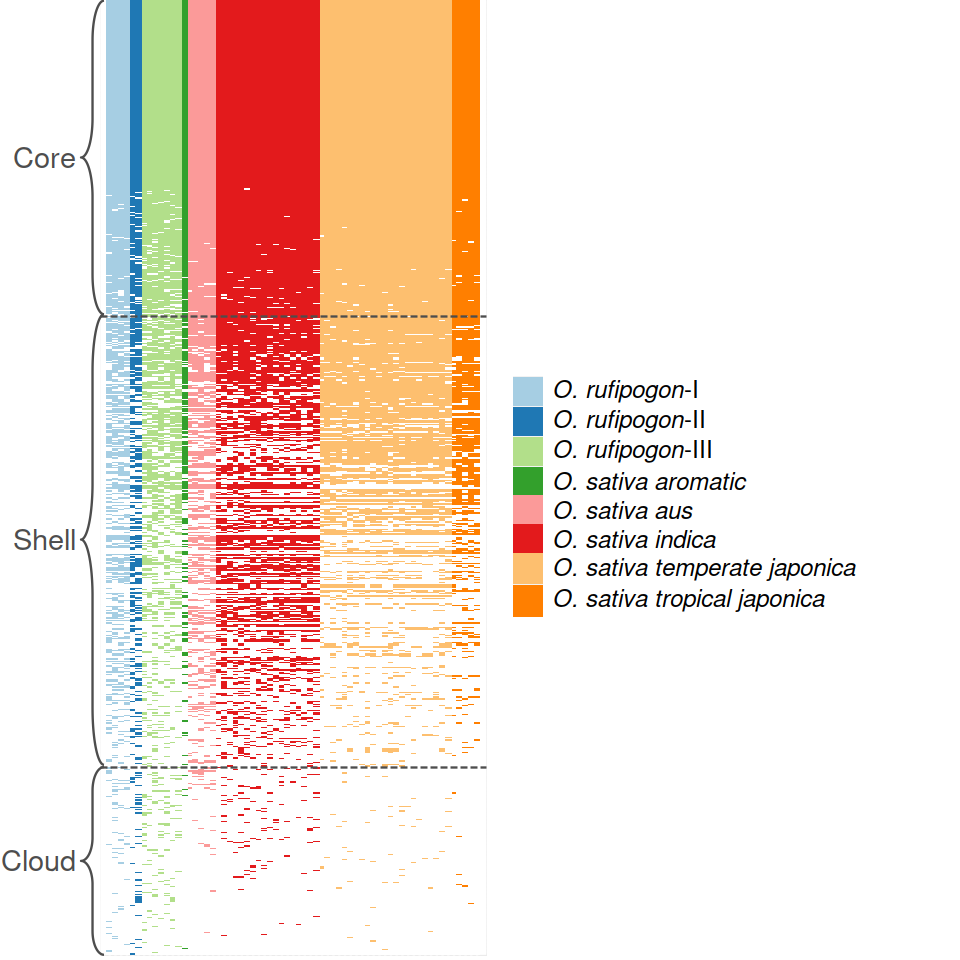

In [17]:
# plot section
suppressMessages(require(ggbrace))
suppressMessages(require(ggrepel))
suppressMessages(require(ggpmisc))

colors <- RColorBrewer::brewer.pal(8, "Paired") 
colors <- c("#FFFFFF", colors)

lab_txt <- expression("",
                      paste(italic("O. rufipogon"), "-I"),
                      paste(italic("O. rufipogon"), "-II"),
                      paste(italic("O. rufipogon"), "-III"),
                      italic("O. sativa aromatic"),
                      italic("O. sativa aus"),
                      italic("O. sativa indica"),
                      italic("O. sativa temperate japonica"),
                      italic("O. sativa tropical japonica"))

options(repr.plot.width = 8, repr.plot.height = 8)
p <- ggplot(input, aes(Assembly_ID, as.factor(HOG))) + 
    geom_tile(aes(fill = as.factor(value)), 
#               show.legend = FALSE
             )+ 
    geom_hline(yintercept = core_shell_sep, linetype="longdash", color="grey30") +
    geom_hline(yintercept = shell_cloud_sep, linetype="longdash", color="grey30") +
    # curly brace
    geom_brace(aes(c(0,-4), c(580, 864),label="Core"), 
                 inherit.data=F, labelsize = 6, color="grey30",  rotate = 270, labelrotate=0)+
    geom_brace(aes(c(0,-4), c(172, 580),label="Shell"), 
                 inherit.data=F, labelsize = 6, color="grey30",  rotate = 270, labelrotate=0)+
    geom_brace(aes(c(0,-4), c(0, 170),label="Cloud"), 
                 inherit.data=F, labelsize = 6, color="grey30",  rotate = 270, labelrotate=0)+
    coord_cartesian(x=range(0, 66), y=range(0,864), clip = "off") + #for the range just use the data for the respective axis
    theme(plot.margin = unit(c(0, 0.1, 0, 0.1), units="npc"))+
    # curly brace
#     geom_text(data=input, aes(y=HOG, x=-9, label=kwn_nlr), check_overlap = T, size=4, color="grey20") +
    theme(axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          legend.title=element_blank(),
          axis.title.x=element_blank(),
          axis.title.y=element_blank(),
          axis.ticks = element_blank(),
          legend.text = element_text(size = 14),
          legend.text.align = 0,
#           legend.position = c(1.2,1)
          legend.position = "right",
          legend.justification = "center"
         )+ 
    scale_fill_manual(values = colors, labels=lab_txt) 
#     guides(fill = guide_legend(ncol = 1)) + 
#     annotate(geom="table", x=109, y=100, label=list(table_input), size=5, parse=T)

p

#### C

In [18]:
# Saturation analyses of pan-NLRome
# data input for total OG
data <- read.csv(paste0(data_path, "hog_saturation_analysis_input_data.csv"),
                 header=TRUE,
                stringsAsFactors=FALSE)
data$comb <- factor(data$comb %>% as.character(), levels=data$comb %>% unique())
data$id_numebr <- data$id_numebr / 100

# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks.y = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_text(size=18, angle=0, margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 5, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.85,0.85),
              legend.text = element_text(size = 14),
              legend.text.align = 0
             )
}

x_lab=c()
for (i in c(0:64)){
    if (i %% 8 == 0){
        x_lab <- append(x_lab, i)
    }else{
        x_lab <- append(x_lab, "")
    }
}

x_lab[1]  <- 1

options(repr.plot.width = 6, repr.plot.height = 4)
s_out <- ggplot(data, aes(comb, id_numebr), fill=comb, color=comb) +
     geom_boxplot(alpha=0.3, width=0.7, 
                  outlier.colour="blue",
                  outlier.size=0.5,
                  color='#00C3FF', fill='#00C3FF') +
     ylab("Fraction of discovered OGs")+
     xlab("Sampled accession number")+
     theme_custom() +
     scale_y_continuous(n.breaks=6,labels=percent_format(accuracy = 1)) +
     scale_x_discrete(labels=x_lab, breaks=x_lab) +
     expand_limits(x=-1)+
     geom_hline(yintercept=0.95, linetype="dashed", color="darkred") + # recover 95% IDs 
     geom_vline(xintercept=32, linetype="dashed", color="darkred") # on average, 32 genotypes could recover 95% rice pan-NLRome
# s_out

In [19]:
# Saturation analyses of indica/japonica/rufipogon
# input data for each species
# bootstrap function
create_bootset <- function(df, species){
    data <- df[!grepl("Miss", df$HOG),]
    data_s <- df[grepl(species, df$Species),]

    total_hog_num <- data_s$HOG %>% unique() %>% length()
    assembly_id <- data_s$Assembly_ID %>% unique()
    assembly_num <- assembly_id %>% length()

    # bootstraping
    comb_no <- c()
    rpt_no <- c()
    hog_no <- c()
    for (i in c(1:assembly_num)){
        for (y in c(1:100)){
            hog_tmp <- assembly_id[sample.int(assembly_num,i)]
            hog_num <- data_s[data_s$Assembly_ID %in% hog_tmp,]$HOG %>% unique() %>% length()
            hog_ratio <- hog_num / total_hog_num
            comb_no <- append(comb_no,i)
            rpt_no <- append(rpt_no,y)
            hog_no <- append(hog_no,hog_ratio)
        }
    }
    data_out <- list("comb"=comb_no, "rpt"=rpt_no, "id_numebr"=hog_no) %>% as.data.frame
#     data_out$comb <- factor(data_out$comb %>% as.character(), levels=data_out$comb %>% unique())
    return(data_out)
}

# set seed
set.seed(2021)

df_or <- create_bootset(df, "rufipogon")
df_oi <- create_bootset(df, "indica")
df_oj <- create_bootset(df, "japonica")

df_or$Species <- "O. rufipogon"
df_oi$Species <- "O. sativa indica"
df_oj$Species <- "O. sativa japonica"

In [20]:
# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(),
              panel.background = element_rect(fill = "transparent",colour = NA),
              plot.background = element_rect(fill = "transparent",colour = NA),
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks.y = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(), 
              axis.title.y = element_blank(), 
              legend.title = element_blank(),
              legend.position = c(0.7,0.4),
              legend.text = element_text(size = 14),
              legend.text.align = 0,
              legend.background = element_rect(fill = "transparent",colour = NA)
             )
}

lab_txt <- expression(italic("O. rufipogon"),
                      italic("Os. japonica"),
                      italic("Os. indica"))

options(repr.plot.width = 3, repr.plot.height = 2)
s_in <- ggplot() +
     geom_boxplot(data=df_or, aes(comb, id_numebr, group=comb, fill=Species, color=Species),alpha=0.3, width=0.7, 
                  outlier.colour="black",
                  outlier.size=0.5,
                  show.legend=TRUE) +
     geom_boxplot(data=df_oi, aes(comb, id_numebr, group=comb, fill=Species, color=Species), alpha=0.3, width=0.7, 
                  outlier.colour="black",
                  outlier.size=0.5, 
                  show.legend=TRUE) +
     geom_boxplot(data=df_oj, aes(comb, id_numebr, group=comb, fill=Species, color=Species),alpha=0.3, width=0.7, 
                  outlier.colour="black",
                  outlier.size=0.5,
                  show.legend=TRUE) +
     stat_summary(data=df_oi, fun=mean, geom="line", aes(comb, id_numebr, group=1), color='green4', size=1) +
     stat_summary(data=df_oj, fun=mean, geom="line", aes(comb, id_numebr, group=1), color='blue', size=1) +
     stat_summary(data=df_or, fun=mean, geom="line", aes(comb, id_numebr, group=1), color='red', size=1) +
     theme_custom() +
     scale_y_continuous(n.breaks=6, labels=percent_format(accuracy = 1)) +
     scale_x_continuous(expand = expansion(mult = c(0, 0.05)),n.breaks=6) +
     scale_fill_npg(labels=lab_txt) +
     scale_color_npg(labels=lab_txt) +
     expand_limits(x=0)
# s_in

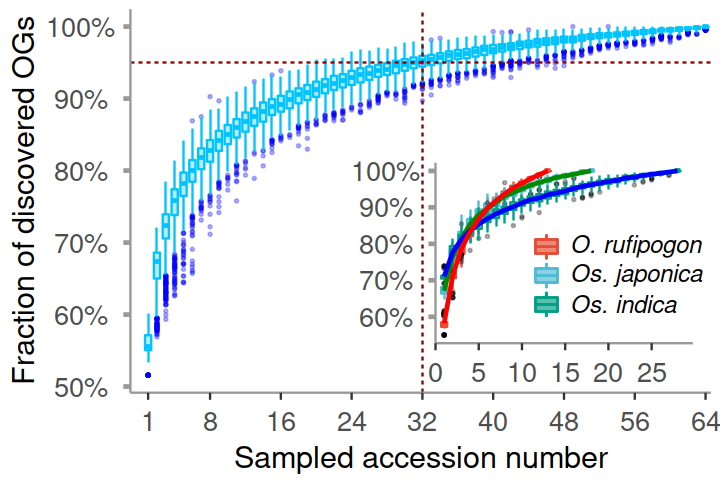

In [21]:
# merge two plots
options(repr.plot.width = 6, repr.plot.height = 4)
p <- ggdraw() +
    draw_plot(s_out, 0, 0, 1, 1) +
    draw_plot(s_in, 0.475, 0.18, 0.5, 0.5)
p

#### D

In [22]:
# load packages and generate input 
suppressMessages(require("UpSetR"))

input_list <- list(
rufipogon = df[df$Species == "O. rufipogon", "HOG"] %>% unique(),
temp_jap = df[df$Species2 == "O. sativa temperate japonica", "HOG"] %>% unique(),
indica = df[df$Species2 == "O. sativa indica", "HOG"] %>% unique(),
aus = df[df$Species2 == "O. sativa aus", "HOG"] %>% unique(),
aromatic = df[df$Species2 == "O. sativa aromatic", "HOG"] %>% unique(),
trop_jap = df[df$Species2 == "O. sativa tropical japonica", "HOG"] %>% unique()
)

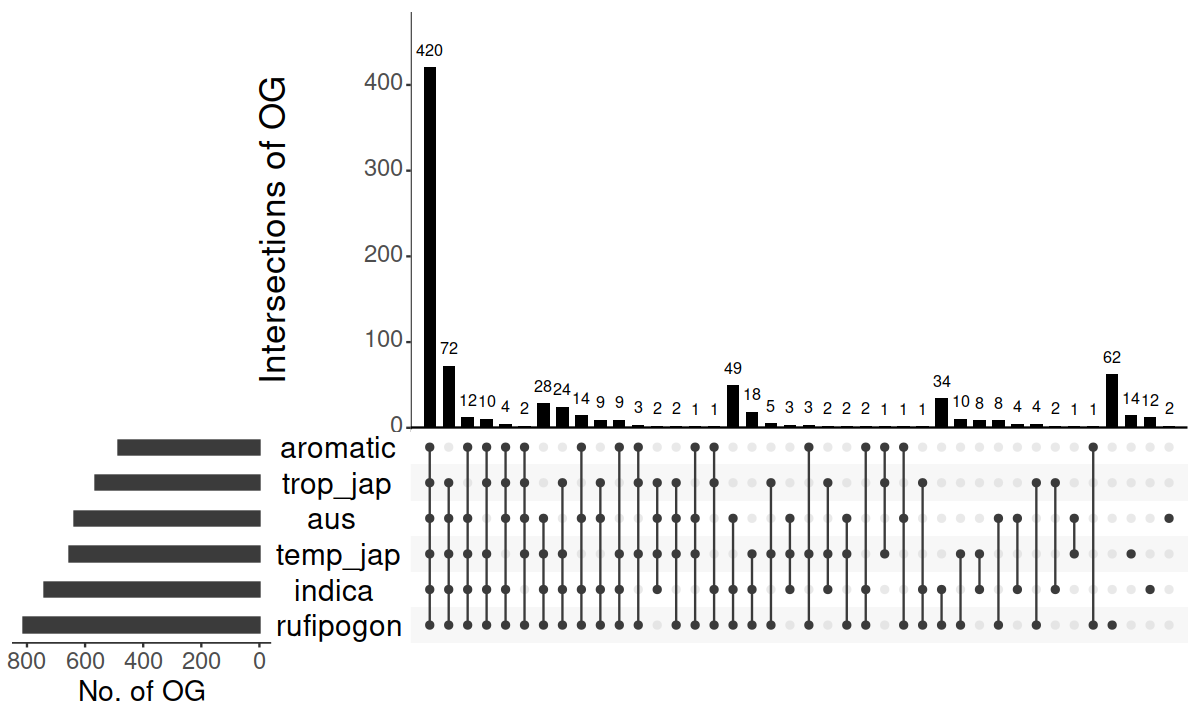

In [23]:
# plot section 
options(repr.plot.width = 10, repr.plot.height = 6)
upset(fromList(input_list), 
      order.by = c("freq", "degree"), 
      decreasing = c(TRUE,TRUE),
      nsets = 6,
      point.size = 2, 
      line.size = 0.5, 
      mb.ratio = c(0.6, 0.4),
      mainbar.y.label = "Intersections of OG", 
      sets.x.label = "No. of OG", 
      text.scale = c(2.5, # ylab size
                     2, # y-tick size
                     2, # xlab size
                     2, # x-tick size
                     2.5, # set label size
                     1.5),
      main.bar.color = "black")

Warning message in sprintf("%d", n, 100 * n/sum(n)):
“one argument not used by format '%d'”


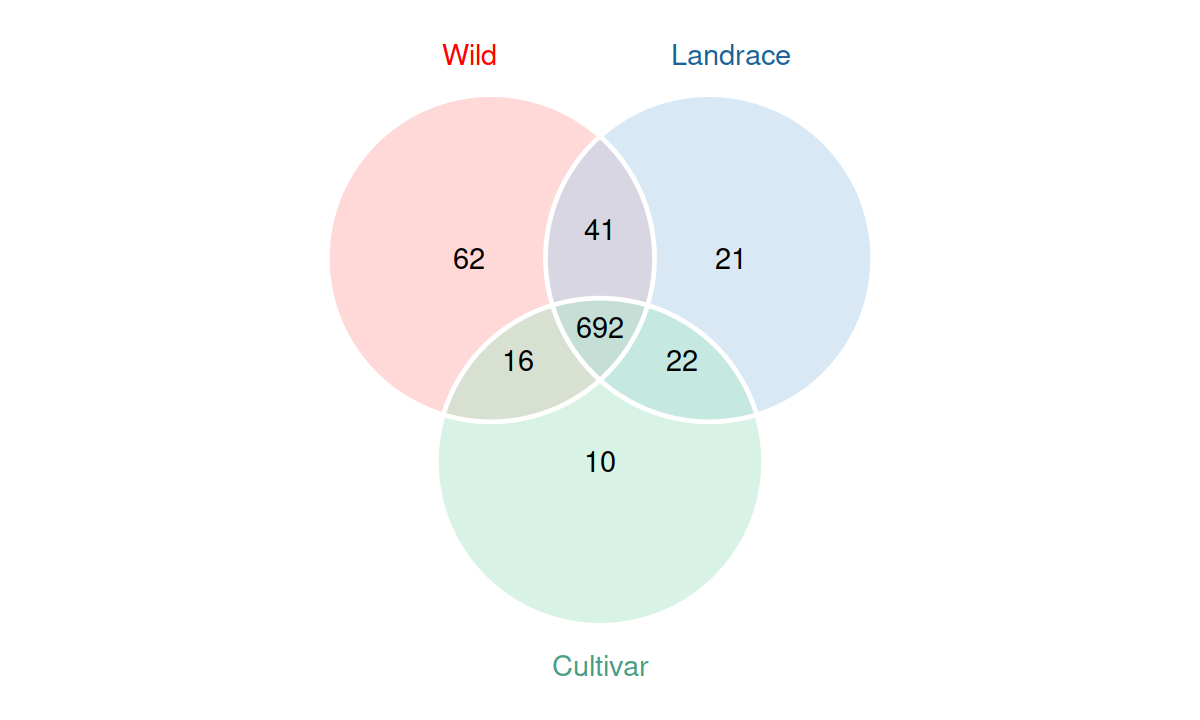

In [24]:
# OG venn diagram
suppressMessages(require(ggvenn))
cult <- df[df$Status == "Cultivar",]$HOG %>% unique() 
land <- df[df$Status == "Landrace",]$HOG %>% unique() 
wild <- df[df$Status == "Wild",]$HOG %>% unique() 

ggvenn(list("Wild"=wild, "Landrace"=land, "Cultivar"=cult),
       c("Wild","Landrace", "Cultivar"),
       show_percentage = F,
       stroke_color = "white",
       text_size = 6,
       fill_color = c("#ffb2b2","#b2d4ec","#b2e7cb"),
       set_name_color = c("#ff0000","#1d6295","#4a9b83"))

#### E

In [25]:
# input data
data <- df[!grepl("Miss", df$HOG),]
data <- data[c('gene_ID','Species2','pangenome_section')] %>% 
    group_by(pangenome_section, Species2) %>% 
    summarise_at(vars(gene_ID), list(length))
data$pangenome_section <- factor(data$pangenome_section, levels=c('Core', 'Shell', 'Cloud'))
# data$Species <- factor(data$Species, levels=c("Wild rice", "Domesticated rice"))

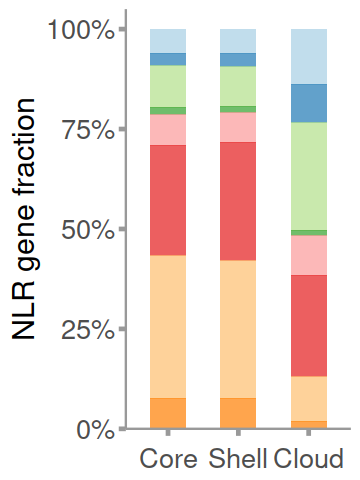

In [26]:
# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid = element_blank(),
              panel.background = element_rect(fill = "transparent",colour = NA),
              plot.background = element_rect(fill = "transparent",colour = NA),
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              strip.text.x = element_blank(),
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.text.y.left = element_text(size=16, 
                                         color="gray30",
                                         hjust=1, vjust = 0.5),
              axis.title.x = element_blank(),
              axis.title.y =  element_text(size=18, angle=90, color="black", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              legend.title = element_blank(),
#               legend.position = c(0.5,0.4),
              legend.position = "right",
              legend.justification = "center",
              legend.text = element_text(size = 16),
              legend.text.align = 0,
#               plot.margin = unit(c(4,1,1,1), "lines") # widden the top margin        
             )
}

# palette
# mypal =pal_npg("nrc", alpha =1)(9)
colors <- RColorBrewer::brewer.pal(8, "Paired") 
lab_txt <- expression(paste(italic("O. rufipogon"), "-I"),
                                      paste(italic("O. rufipogon"), "-II"),
                                      paste(italic("O. rufipogon"), "-III"),
                                      italic("O. sativa aromatic"),
                                      italic("O. sativa aus"),
                                      italic("O. sativa indica"),
                                      italic("O. sativa temperate japonica"),
                                      italic("O. sativa tropical japonica"))

options(repr.plot.width = 3, repr.plot.height = 4)

p <- ggplot(data, aes(fill = Species2,
                     y = gene_ID, 
                     x = pangenome_section))+
        geom_bar(position = "fill", stat = "identity", alpha=0.7, width=0.5, show.legend=F)+
        scale_y_continuous(expand = expansion(mult = c(0, 0.05)),
                           labels=percent_format(accuracy = 1)
                           )+
        theme_custom() +
#         scale_fill_npg() +
        ylab("NLR gene fraction") +
#         guides(fill=guide_legend(ncol=1)) +
        coord_cartesian(ylim=c(0,1),clip = 'off') +
    scale_color_manual(values = colors, labels=lab_txt) +
    scale_fill_manual(values = colors, labels=lab_txt) 

p

#### F

In [27]:
# input data
data <- df[!grepl("Miss", df$HOG),]
data <- data[c('gene_ID','Status','pangenome_section')] %>% 
    group_by(pangenome_section,Status) %>% 
    summarise_at(vars(gene_ID), list(length))
data$pangenome_section <- factor(data$pangenome_section, levels=c('Core', 'Shell', 'Cloud'))
data$Status2 <- factor(data$Status, levels=c("Wild", "Landrace", "Cultivar"))

# the gene number for each pan-genome sectionn
core_num <- data[data$pangenome_section=="Core",]$gene_ID
shell_num <- data[data$pangenome_section=="Shell",]$gene_ID
cloud_num <- data[data$pangenome_section=="Cloud",]$gene_ID

Warning message:
“Manual legend position not possible for collected guides. Defaulting to 'right'”
Warning message:
“Manual position of collected guides not supported”


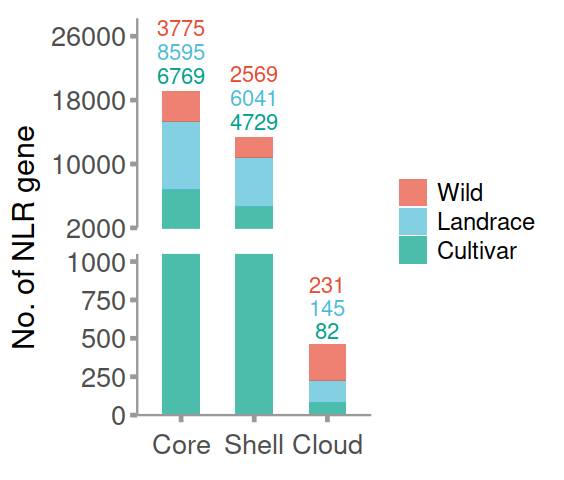

In [28]:
# plot section
suppressMessages(require(ggbreak))
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid = element_blank(),
              panel.background = element_rect(fill = "transparent",colour = NA),
              plot.background = element_rect(fill = "transparent",colour = NA),
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              strip.text.x = element_blank(),
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.text.y.left = element_text(size=16, 
                                         color="gray30",
                                         hjust=1, vjust = 0.5),
              axis.title.x = element_blank(),
              axis.title.y =  element_text(size=18, angle=90, color="black", margin = margin(t = 0, r = 0, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.74,0.9),
#               legend.position = "right",
#               legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0,
#               plot.margin = unit(c(4,1,1,1), "lines") # widden the top margin        
             )
}

# palette
mypal =pal_npg("nrc", alpha =1)(9)

options(repr.plot.width = 4.7, repr.plot.height = 4)

p <- ggplot(data, aes(fill = Status2,
                     y = gene_ID, 
                     x = pangenome_section))+
        geom_bar(position = "stack", stat = "identity", alpha=0.7, width=0.5)+
#         scale_y_continuous(expand = expansion(mult = c(0, 0.05)))+
        scale_y_break(c(1000, 2000), 
                      scale = 1.3,
                      space = 0.4,
                      ticklabels = c(2000,  10000, 18000, 26000),
                      expand = expansion(mult = c(0, 0.05))) +
        theme_custom() +
        scale_fill_npg() +
        ylab("No. of NLR gene") +
        guides(fill=guide_legend(nrow=3)) +
        annotate(geom="text", x=1, 
                 y=c(21000, 24000, 27000), label=c(core_num[1], core_num[2], core_num[3]), 
                 size=4.5, color=rev(mypal[1:3])) +
        annotate(geom="text", x=2, 
                 y=c(15300, 18300, 21300), label=c(shell_num[1], shell_num[2], shell_num[3]), 
                 size=4.5, color=rev(mypal[1:3])) +
        annotate(geom="text", x=3, 
                 y=c(550, 700, 850), label=c(cloud_num[1], cloud_num[2], cloud_num[3]), 
                 size=4.5, color=rev(mypal[1:3])) 
p

### Figure 3
The NLRs with LRR domain were preferably retained after domestication.

#### A

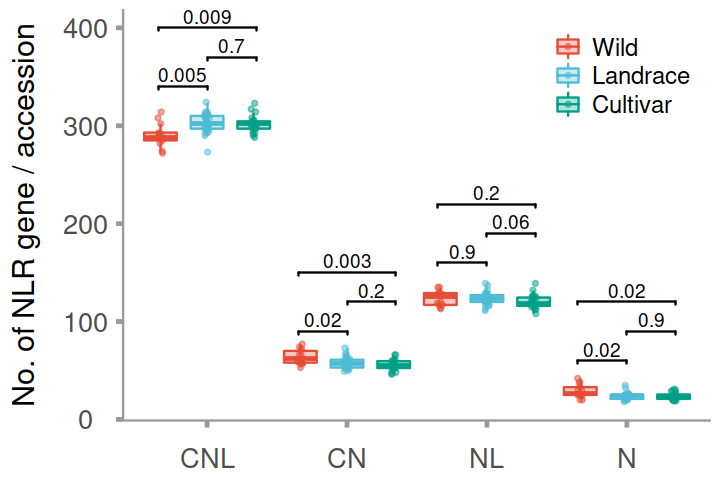

In [29]:
# generate input
data <- df[, c('gene_ID', 'Status', 'Assembly_ID')]

data$NLR_class = gsub("X","", df$New2_NLR_class)

data <- df[, c('gene_ID', 'Status', 'Assembly_ID')]
data$NLR_class = gsub("X","", df$New2_NLR_class)

data <- data %>% group_by(NLR_class, Status, Assembly_ID) %>% 
               summarise_at(vars(gene_ID), list(length))

data$NLR_class <- factor(data$NLR_class, 
#                          levels=unique(data[order(-data$gene_ID),]$NLR_class),
                         levels=c('CNL', 'CN', 'NL', 'N'))
data$Status <- factor(data$Status, levels=c('Cultivar', 'Landrace', 'Wild'))
data$Status <- factor(data$Status, levels=c("Wild", "Landrace", "Cultivar"))

# filter out the NLR_class that is too low
data <- data[data$gene_ID >2,]

# add significance annotation
sig_cl <- c()
sig_cw <- c()
sig_lw <- c()
status <- c("Cultivar", "Landrace", "Wild")
for (arch in unique(data[order(-data$gene_ID),]$NLR_class)){
    df_tmp <- data[(data$NLR_class == arch),]
    #
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[1]),]$gene_ID, 
                     df_tmp[(df_tmp$Status == status[2]),]$gene_ID)$p.value
    sig_cl <- append(sig_cl, pvalue)
    #
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[1]),]$gene_ID, 
                     df_tmp[(df_tmp$Status == status[3]),]$gene_ID)$p.value
    sig_cw <- append(sig_cw, pvalue)
    #
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[2]),]$gene_ID, 
                     df_tmp[(df_tmp$Status == status[3]),]$gene_ID)$p.value
    sig_lw <- append(sig_lw, pvalue)    
} 

# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 10, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 15, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.85,0.85),
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0
             )
}

# sig annotation position
sig_pos_y = c(340, 370, 400)
sig_pos_x_min = c(0.65,1,0.65)
sig_pos_x_max = c(1,1.35,1.35)

options(repr.plot.width = 6, repr.plot.height = 4)
p <- ggplot(data, aes(NLR_class, gene_ID, fill=Status, color=Status)) +
     geom_boxplot(alpha=0.3, width=0.7, 
                  position = position_dodge(1),
                  outlier.colour="transparent") +
     geom_jitter(size=1, 
                 alpha=0.5,
                 position = position_jitterdodge(jitter.width=0.1, dodge.width=1)) + 
     ylab("No. of NLR gene / accession")+
     theme_custom() +
     scale_fill_npg() +
     scale_color_npg() +
     scale_y_continuous(n.breaks=6) +
     geom_signif(y_position=sig_pos_y, color='black',
                xmin=sig_pos_x_min, xmax=sig_pos_x_max, tip_length=0.01,
                annotation=formatC(c(sig_lw[1], sig_cl[1], sig_cw[1]), digits=1)) +
     geom_signif(y_position=sig_pos_y - 180, color='black',
                xmin=sig_pos_x_min +2 , xmax=sig_pos_x_max +2 , tip_length=0.01,
                annotation=formatC(c(sig_lw[2], sig_cl[2], sig_cw[2]), digits=1)) +
     geom_signif(y_position=sig_pos_y - 250, color='black',
                xmin=sig_pos_x_min +1 , xmax=sig_pos_x_max +1 , tip_length=0.01,
                annotation=formatC(c(sig_lw[3], sig_cl[3], sig_cw[3]), digits=1)) +
     geom_signif(y_position=sig_pos_y - 280, color='black',
                xmin=sig_pos_x_min +3 , xmax=sig_pos_x_max +3 , tip_length=0.01,
                annotation=formatC(c(sig_lw[4], sig_cl[4], sig_cw[4]), digits=1))
p

####  B

In [30]:
# generate input
data <- df[c('gene_ID', 'Species2', 'Assembly_ID')]

data$NLR_class = gsub("X","", df$New2_NLR_class)

data <- data %>% group_by(NLR_class, Species2, Assembly_ID) %>% 
               summarise_at(vars(gene_ID), list(length))

data$NLR_class <- factor(data$NLR_class, 
                         levels=c('CNL', 'CN', 'NL', 'N'))
# data$Status <- factor(data$Status, levels=c('Cultivar', 'Landrace', 'Wild'))
# filter out the NLR_class of which NLR number less than 3
data <- data[data$gene_ID >2,]

In [31]:
# generate significance annotation
suppressMessages(require("agricolae"))
aov_sig <- function(data, NLR_class, threshold=0.01){
    oneway <- aov(gene_ID~Species2, data=data[data$NLR_class==NLR_class,])
    lsd_ad <- LSD.test(oneway, "Species2", p.adj="bonferroni", alpha=threshold)
    lsd_ad1 <- lsd_ad$groups
    lsd_ad2 <- data.frame(Species2 = row.names(lsd_ad1),
                          sig = lsd_ad1$groups)
    lsd_ad2 <- lsd_ad2[order(lsd_ad2$Species2),]
    lsd_ad2$c_type <- NLR_class
    max_value <- data[data$NLR_class==NLR_class,]  %>% group_by(Species2) %>% 
                    summarise_at(vars(gene_ID), list(max))
    lsd_ad2$max <- max_value$gene_ID
    return(lsd_ad2)
}

df_sig <- rbind(aov_sig(data, "CNL"), 
              aov_sig(data, "CN"), 
              aov_sig(data, "NL"),
               aov_sig(data, "N"))

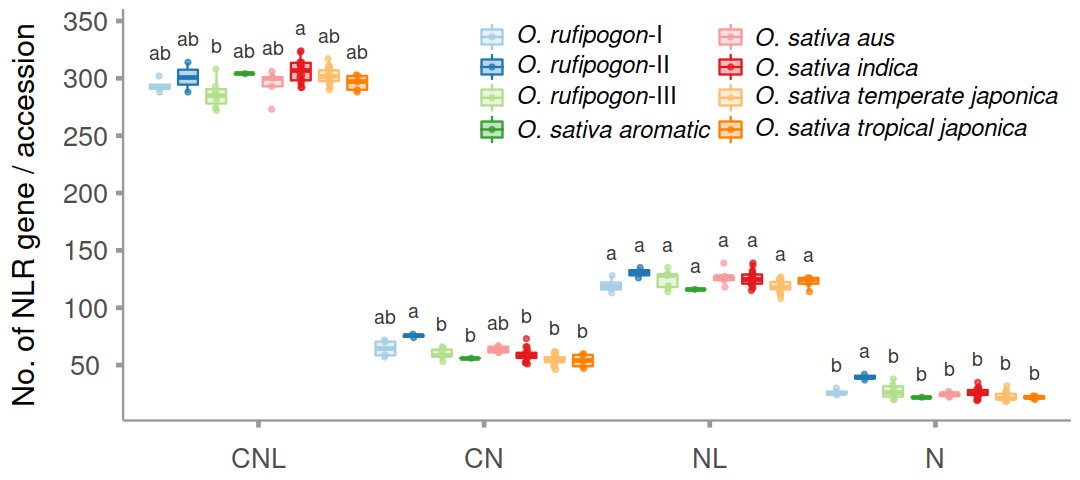

In [32]:
# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 10, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 15, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.68,0.83),
#               legend.position = "right",
#               legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0,
              legend.background = element_rect(fill = "transparent", colour = "transparent")
             )
}

colors <- RColorBrewer::brewer.pal(9, "Paired") 

options(repr.plot.width = 9, repr.plot.height = 4)
p <- ggplot(data, aes(NLR_class, gene_ID, fill=Species2, color=Species2)) +
     geom_boxplot(alpha=0.3, width=0.7, size=0.5,
                  position = position_dodge(1),
                  outlier.colour="transparent") +
     geom_jitter(size=1,alpha=0.7,
                 position = position_jitterdodge(jitter.width=0.01, dodge.width=1)) + 
     geom_text(data=df_sig, aes(x=c_type, y=max+20, label=sig), 
               position = position_dodge(1),
               color="grey20", size=4)+
     ylab("No. of NLR gene / accession")+
     theme_custom() +
     scale_y_continuous(n.breaks=7) +
    scale_color_manual(values = colors,
                     labels=expression(paste(italic("O. rufipogon"), "-I"),
                                      paste(italic("O. rufipogon"), "-II"),
                                      paste(italic("O. rufipogon"), "-III"),
                                      italic("O. sativa aromatic"),
                                      italic("O. sativa aus"),
                                      italic("O. sativa indica"),
                                      italic("O. sativa temperate japonica"),
                                      italic("O. sativa tropical japonica"))) +
    scale_fill_manual(values=colors,
                     labels=expression(paste(italic("O. rufipogon"), "-I"),
                                      paste(italic("O. rufipogon"), "-II"),
                                      paste(italic("O. rufipogon"), "-III"),
                                      italic("O. sativa aromatic"),
                                      italic("O. sativa aus"),
                                      italic("O. sativa indica"),
                                      italic("O. sativa temperate japonica"),
                                      italic("O. sativa tropical japonica"))) +
    guides(fill=guide_legend(ncol=2)) +
    guides(color=guide_legend(ncol=2))

p

#### C

In [33]:
# base dataframe: grep all NLRs meet the requirement 
# 1. all NLR
data_all <- df[,c('gene_ID', 'Assembly_ID', 'Status', 'New2_NLR_class')] 
data_all$c_type = "All"

# 2. clustered NLR
data_clu <- df[grepl("Concat", df$Clustered_Type),][,c('gene_ID', 'Assembly_ID', 'Status', 'New2_NLR_class')] 

# 3. paired NLR
data_pair <- df[df$Pair_partner_new !="-",][c('gene_ID', 'Assembly_ID', 'Status', 'New2_NLR_class')]

# Function to filter with/without a certain domain
count_domain_L <- function (col_list) {
    result_list <- c()
    for (i in col_list){
        if (grepl('L', i)) {
            result_list <- append(result_list, "yes")
        } else {
            result_list <- append(result_list, "no")            
        }
    }
    return(result_list)
}

# Function2 to calculate LRR% 
calc_LRR_percent <- function(df, cluster_type) {
    
    df$with_domain <- count_domain_L(df$New2_NLR_class)

    df_sum <- df %>% group_by(Status, Assembly_ID, with_domain) %>% 
                summarise_at(vars(gene_ID), list(length))

    df_sum <- spread(df_sum, with_domain, gene_ID) # reshape longform to wideform
    
    df_sum[is.na(df_sum)] <- 0 # fill NA with 0
    
    df_sum$domain_percent <- df_sum$yes / (df_sum$yes + df_sum$no)    

    df_sum$c_type <- cluster_type

    return(df_sum)
}

# calculate LRR%
data_all_input <- calc_LRR_percent(data_all, 'All')
data_clu_input <- calc_LRR_percent(data_clu, 'Clustered')
data_pair_input <- calc_LRR_percent(data_pair, 'Paired')

# entire input
data <- rbind(data_all_input, data_clu_input, data_pair_input)
# order stauts
data$Status <- factor(data$Status, levels=c("Wild", "Landrace", "Cultivar"))

# add significance annotation for status
sig_cl <- c()
sig_cw <- c()
sig_lw <- c()
status <- c("Cultivar", "Landrace", "Wild")
for (i in unique(data$c_type)){
    df_tmp <- data[(data$c_type == i),]
#     print(i)
    #
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[1]),]$domain_percent, 
                     df_tmp[(df_tmp$Status == status[2]),]$domain_percent)$p.value
    sig_cl <- append(sig_cl, pvalue)
    #
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[1]),]$domain_percent, 
                     df_tmp[(df_tmp$Status == status[3]),]$domain_percent)$p.value
    sig_cw <- append(sig_cw, pvalue)
    #
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[2]),]$domain_percent, 
                     df_tmp[(df_tmp$Status == status[3]),]$domain_percent)$p.value
    sig_lw <- append(sig_lw, pvalue)    
}


# add significance annotation for clustered type
all_vs_clu <- t.test(data[(data$c_type == "All"),]$domain_percent, 
                     data[(data$c_type == "Clustered"),]$domain_percent)$p.value
clu_vs_pir <- t.test(data[(data$c_type == "Clustered"),]$domain_percent, 
                     data[(data$c_type == "Paired"),]$domain_percent)$p.value
all_vs_pir <- t.test(data[(data$c_type == "All"),]$domain_percent, 
                     data[(data$c_type == "Paired"),]$domain_percent)$p.value

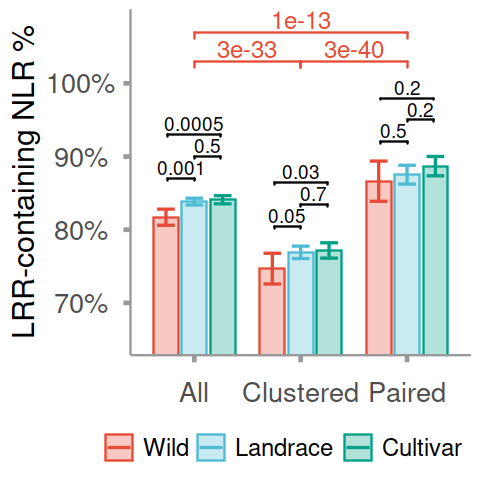

In [34]:
# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              complete = TRUE,
#               axis.text.x = element_blank(),
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 10, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 5, b = 0, l = 0)),
              legend.title = element_blank(),
#               legend.position = c(0.87,0.9),
              legend.position = "bottom",
              legend.justification = "right",
              legend.text = element_text(size = 14),
              legend.text.align = 0)
#               legend.position = "none")
}

# sig annotation position for status
sig_pos_y = c(0.87, 0.90, 0.93)
sig_pos_x_min = c(0.75,1,0.75)
sig_pos_x_max = c(1,1.25,1.25)

# sig annotation position for status
sig_pos_Y = c(1.05, 1.05, 1.09)
sig_pos_X_min = c(1,2,1)
sig_pos_X_max = c(2,3,3)

options(repr.plot.width = 4, repr.plot.height = 4)
p1 <- ggplot(data, aes(c_type, domain_percent, fill=Status, color=Status)) +
#     ggtitle("LRR") +
    stat_summary(fun="mean", 
                 geom="col", 
                 alpha=0.3, 
                 width=0.7, 
                 position = position_dodge(0.8)
                ) + 
    stat_summary(fun.data = mean_cl_normal, 
                 geom = "errorbar",
                 width=0.5, 
                 position = position_dodge(0.8),
                 size=0.7) +      
#      geom_jitter(size=1,
#                  alpha=0.5,
#                  position = position_jitterdodge(jitter.width=0.1, dodge.width=0.8)) + 
     ylab("LRR-containing NLR %") +
     theme_custom() +
     scale_fill_npg() +
     scale_color_npg() +
     scale_y_continuous(limits=c(0.65,1.08), 
#                         n.breaks=6,
                        oob = rescale_none,
                        breaks=c(.7, .8, .9, 1),
                        labels=percent_format(accuracy = 1)) +
     geom_signif(y_position=sig_pos_y, color='black',
                xmin=sig_pos_x_min, xmax=sig_pos_x_max, tip_length=0.01,
                annotation=formatC(c(sig_lw[1], sig_cl[1],  sig_cw[1]), digits=1)) +
     geom_signif(y_position=sig_pos_y - 0.065, color='black',
                xmin=sig_pos_x_min + 1 , xmax=sig_pos_x_max +1 , tip_length=0.01,
                annotation=formatC(c(sig_lw[2], sig_cl[2], sig_cw[2]), digits=1)) +
     geom_signif(y_position=sig_pos_y + 0.05, color='black',
                xmin=sig_pos_x_min +2 , xmax=sig_pos_x_max +2 , tip_length=0.01,
                annotation=formatC(c(sig_lw[3], sig_cl[3], sig_cw[3]), digits=1)) +
     geom_signif(y_position=sig_pos_Y-0.02, textsize=5,
                xmin=sig_pos_X_min, xmax=sig_pos_X_max, tip_length=0.03,
                annotation=formatC(c(all_vs_clu, clu_vs_pir, all_vs_pir), digits=1))
p1

#### D

In [35]:
# base dataframe: grep all NLRs meet the requirement 
# 1. all NLR
data_all <- df[,c('gene_ID', 'Assembly_ID', 'Status', 'New2_NLR_class')] 
data_all$c_type = "All"

# 2. clustered NLR
data_clu <- df[grepl("Concat", df$Clustered_Type),][,c('gene_ID', 'Assembly_ID', 'Status', 'New2_NLR_class')] 

# 3. paired NLR
data_pair <- df[df$Pair_partner_new !="-",][c('gene_ID', 'Assembly_ID', 'Status', 'New2_NLR_class')]

# Function to filter with/without a certain domain
count_domain_L <- function (col_list) {
    result_list <- c()
    for (i in col_list){
        if (grepl('C', i)) {
            result_list <- append(result_list, "yes")
        } else {
            result_list <- append(result_list, "no")            
        }
    }
    return(result_list)
}

# Function2 to calculate CC% 
calc_LRR_percent <- function(df, cluster_type) {
    
    df$with_domain <- count_domain_L(df$New2_NLR_class)

    df_sum <- df %>% group_by(Status, Assembly_ID, with_domain) %>% 
                summarise_at(vars(gene_ID), list(length))

    df_sum <- spread(df_sum, with_domain, gene_ID) # reshape longform to wideform
    
    df_sum[is.na(df_sum)] <- 0 # fill NA with 0
    
    df_sum$domain_percent <- df_sum$yes / (df_sum$yes + df_sum$no)    

    df_sum$c_type <- cluster_type

    return(df_sum)
}

# calculate CC%
data_all_input <- calc_LRR_percent(data_all, 'All')
data_clu_input <- calc_LRR_percent(data_clu, 'Clustered')
data_pair_input <- calc_LRR_percent(data_pair, 'Paired')

# entire input
data <- rbind(data_all_input, data_clu_input, data_pair_input)
# order stauts
data$Status <- factor(data$Status, levels=c("Wild", "Landrace", "Cultivar"))

# add significance annotation for status
sig_cl <- c()
sig_cw <- c()
sig_lw <- c()
status <- c("Cultivar", "Landrace", "Wild")
for (i in unique(data$c_type)){
    df_tmp <- data[(data$c_type == i),]
#     print(i)
    #
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[1]),]$domain_percent, 
                     df_tmp[(df_tmp$Status == status[2]),]$domain_percent)$p.value
    sig_cl <- append(sig_cl, pvalue)
    #
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[1]),]$domain_percent, 
                     df_tmp[(df_tmp$Status == status[3]),]$domain_percent)$p.value
    sig_cw <- append(sig_cw, pvalue)
    #
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[2]),]$domain_percent, 
                     df_tmp[(df_tmp$Status == status[3]),]$domain_percent)$p.value
    sig_lw <- append(sig_lw, pvalue)    
}


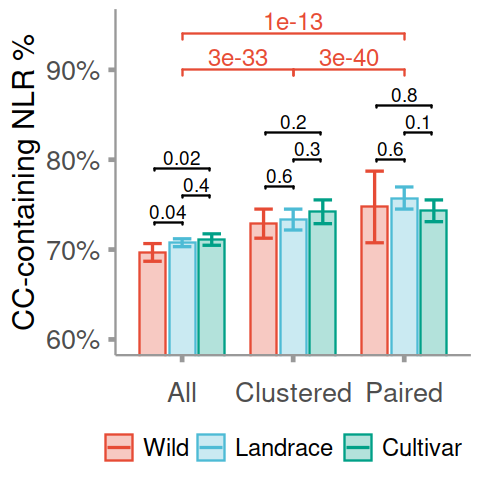

In [36]:
# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              complete = TRUE,
#               axis.text.x = element_blank(),
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 10, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 5, b = 0, l = 0)),
              legend.title = element_blank(),
#               legend.position = c(0.87,0.9),
              legend.position = "bottom",
              legend.justification = "right",
              legend.text = element_text(size = 14),
              legend.text.align = 0,
#               legend.position = "none")
             )
}

# sig annotation position for status
sig_pos_y = c(0.76, 0.79, 0.82)
sig_pos_x_min = c(0.75,1,0.75)
sig_pos_x_max = c(1,1.25,1.25)

# sig annotation position for status
sig_pos_Y = c(0.95, .95, .99)
sig_pos_X_min = c(1,2,1)
sig_pos_X_max = c(2,3,3)

options(repr.plot.width = 4, repr.plot.height = 4)
p <- ggplot(data, aes(c_type, domain_percent, fill=Status, color=Status)) +
    stat_summary(fun="mean", 
                 geom="col", 
                 alpha=0.3, 
                 width=0.7, 
                 position = position_dodge(0.8)
                ) + 
    stat_summary(fun.data = mean_cl_normal, 
                 geom = "errorbar",
                 width=0.5, 
                 position = position_dodge(0.8),
                 size=0.7) +      
     ylab("CC-containing NLR %")+
     theme_custom() +
     scale_fill_npg() +
     scale_color_npg() +
     scale_y_continuous(limits=c(0.6,0.95), n.breaks=6,
                        oob = rescale_none,
                        labels=percent_format(accuracy = 1)) +
     geom_signif(y_position=sig_pos_y - 0.03, color='black',
                xmin=sig_pos_x_min, xmax=sig_pos_x_max, tip_length=0.01,
                annotation=formatC(c(sig_lw[1], sig_cl[1], sig_cw[1]), digits=1)) +
     geom_signif(y_position=sig_pos_y + 0.01, color='black',
                xmin=sig_pos_x_min + 1 , xmax=sig_pos_x_max +1 , tip_length=0.01,
                annotation=formatC(c(sig_lw[2], sig_cl[2], sig_cw[2]), digits=1)) +
     geom_signif(y_position=sig_pos_y + 0.04, color='black',
                xmin=sig_pos_x_min +2 , xmax=sig_pos_x_max +2 , tip_length=0.01,
                annotation=formatC(c(sig_lw[3], sig_cl[3], sig_cw[3]), digits=1)) +
     geom_signif(y_position=sig_pos_Y-0.05, textsize=5,
                xmin=sig_pos_X_min, xmax=sig_pos_X_max, tip_length=0.03,
#                 annotation=formatC(c(pir_vs_clu, sgl_vs_pir, clu_vs_sgl), digits=1))
                annotation=formatC(c(all_vs_clu, clu_vs_pir, all_vs_pir), digits=1))
                 
p

#### E

In [37]:
# base dataframe: grep all NLRs meet the requirement 
# 1. all NLR
data_all <- df[,c('gene_ID', 'Assembly_ID', 'Status', 'New2_NLR_class')] 
data_all$c_type = "All"

# 2. clustered NLR
data_clu <- df[grepl("Concat", df$Clustered_Type),][,c('gene_ID', 'Assembly_ID', 'Status', 'New2_NLR_class')] 

# 3. paired NLR
data_pair <- df[df$Pair_partner_new !="-",][c('gene_ID', 'Assembly_ID', 'Status', 'New2_NLR_class')]

# Function to filter with/without a certain domain
count_domain_L <- function (col_list) {
    result_list <- c()
    for (i in col_list){
        if (i == "N") {
            result_list <- append(result_list, "yes")
        } else {
            result_list <- append(result_list, "no")            
        }
    }
    return(result_list)
}

# Function2 to calculate N% 
calc_LRR_percent <- function(df, cluster_type) {
    
    df$with_domain <- count_domain_L(df$New2_NLR_class)

    df_sum <- df %>% group_by(Status, Assembly_ID, with_domain) %>% 
                summarise_at(vars(gene_ID), list(length))

    df_sum <- spread(df_sum, with_domain, gene_ID) # reshape longform to wideform
    
    df_sum[is.na(df_sum)] <- 0 # fill NA with 0
    
    df_sum$domain_percent <- df_sum$yes / (df_sum$yes + df_sum$no)    

    df_sum$c_type <- cluster_type

    return(df_sum)
}

# calculate N%
data_all_input <- calc_LRR_percent(data_all, 'All')
data_clu_input <- calc_LRR_percent(data_clu, 'Clustered')
data_pair_input <- calc_LRR_percent(data_pair, 'Paired')

# entire input
data <- rbind(data_all_input, data_clu_input, data_pair_input)
# order stauts
data$Status <- factor(data$Status, levels=c("Wild", "Landrace", "Cultivar"))

# add significance annotation for status
sig_cl <- c()
sig_cw <- c()
sig_lw <- c()
status <- c("Cultivar", "Landrace", "Wild")
for (i in unique(data$c_type)){
    df_tmp <- data[(data$c_type == i),]
#     print(i)
    #
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[1]),]$domain_percent, 
                     df_tmp[(df_tmp$Status == status[2]),]$domain_percent)$p.value
    sig_cl <- append(sig_cl, pvalue)
    #
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[1]),]$domain_percent, 
                     df_tmp[(df_tmp$Status == status[3]),]$domain_percent)$p.value
    sig_cw <- append(sig_cw, pvalue)
    #
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[2]),]$domain_percent, 
                     df_tmp[(df_tmp$Status == status[3]),]$domain_percent)$p.value
    sig_lw <- append(sig_lw, pvalue)    
}


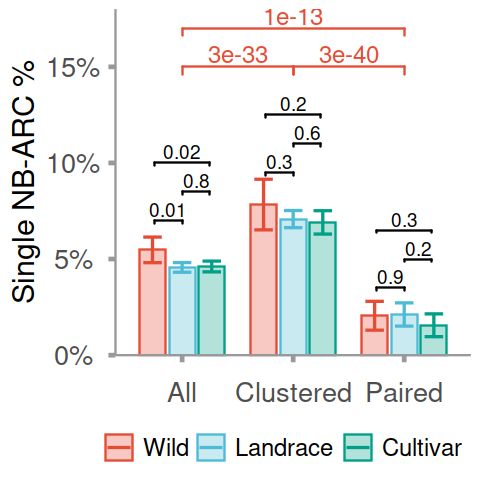

In [38]:
# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              complete = TRUE,
#               axis.text.x = element_blank(),
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 10, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 5, b = 0, l = 0)),
              legend.title = element_blank(),
#               legend.position = c(0.87,0.9),
              legend.position = "bottom",
              legend.justification = "right",
              legend.text = element_text(size = 14),
              legend.text.align = 0,
#               legend.position = "none")
             )
}

# sig annotation position for status
sig_pos_y = c(0.07, 0.085, 0.10)
sig_pos_x_min = c(0.75,1,0.75)
sig_pos_x_max = c(1,1.25,1.25)

# sig annotation position for status
sig_pos_Y = c(0.17, 0.17, 0.19)
sig_pos_X_min = c(1,2,1)
sig_pos_X_max = c(2,3,3)

options(repr.plot.width = 4, repr.plot.height = 4)
p <- ggplot(data, aes(c_type, domain_percent, fill=Status, color=Status)) +
    stat_summary(fun="mean", 
                 geom="col", 
                 alpha=0.3, 
                 width=0.7, 
                 position = position_dodge(0.8)
                ) + 
    stat_summary(fun.data = mean_cl_normal, 
                 geom = "errorbar",
                 width=0.5, 
                 position = position_dodge(0.8),
                 size=0.7) +      
     ylab("Single NB-ARC %")+
     theme_custom() +
     scale_fill_npg() +
     scale_color_npg() +
     scale_y_continuous(limits=c(0,0.18), n.breaks=6,
                        oob = rescale_none,
                        expand = c(0, 0),
                        labels=percent_format(accuracy = 1)) +
     geom_signif(y_position=sig_pos_y, color='black',
                xmin=sig_pos_x_min, xmax=sig_pos_x_max, tip_length=0.01,
                annotation=formatC(c(sig_lw[1], sig_cl[1], sig_cw[1]), digits=1)) +
     geom_signif(y_position=sig_pos_y + 0.025, color='black',
                xmin=sig_pos_x_min + 1 , xmax=sig_pos_x_max +1 , tip_length=0.01,
                annotation=formatC(c(sig_lw[2], sig_cl[2], sig_cw[2]), digits=1)) +
     geom_signif(y_position=sig_pos_y -0.035, color='black',
                xmin=sig_pos_x_min +2 , xmax=sig_pos_x_max +2 , tip_length=0.01,
                annotation=formatC(c(sig_lw[3], sig_cl[3], sig_cw[3]), digits=1)) +
     geom_signif(y_position=sig_pos_Y-0.02, textsize=5,
                xmin=sig_pos_X_min, xmax=sig_pos_X_max, tip_length=0.03,
                annotation=formatC(c(all_vs_clu, clu_vs_pir, all_vs_pir), digits=1))

p

#### F

In [39]:
# base dataframe: grep all NLRs meet the requirement 
# 1. all NLR
data_all <- df[,c('gene_ID', 'Assembly_ID', 'Status', 'New2_NLR_class')] 
data_all$c_type = "All"

# 2. clustered NLR
data_clu <- df[grepl("Concat", df$Clustered_Type),][,c('gene_ID', 'Assembly_ID', 'Status', 'New2_NLR_class')] 

# 3. paired NLR
data_pair <- df[df$Pair_partner_new !="-",][c('gene_ID', 'Assembly_ID', 'Status', 'New2_NLR_class')]

# Function to filter with/without a certain domain
count_domain_L <- function (col_list) {
    result_list <- c()
    for (i in col_list){
        if (grepl('X', i)) {
            result_list <- append(result_list, "yes")
        } else {
            result_list <- append(result_list, "no")            
        }
    }
    return(result_list)
}

# Function2 to calculate X% 
calc_LRR_percent <- function(df, cluster_type) {
    
    df$with_domain <- count_domain_L(df$New2_NLR_class)

    df_sum <- df %>% group_by(Status, Assembly_ID, with_domain) %>% 
                summarise_at(vars(gene_ID), list(length))

    df_sum <- spread(df_sum, with_domain, gene_ID) # reshape longform to wideform
    
    df_sum[is.na(df_sum)] <- 0 # fill NA with 0
    
    df_sum$domain_percent <- df_sum$yes / (df_sum$yes + df_sum$no)    

    df_sum$c_type <- cluster_type

    return(df_sum)
}

# calculate X%
data_all_input <- calc_LRR_percent(data_all, 'All')
data_clu_input <- calc_LRR_percent(data_clu, 'Clustered')
data_pair_input <- calc_LRR_percent(data_pair, 'Paired')

# entire input
data <- rbind(data_all_input, data_clu_input, data_pair_input)
# order stauts
data$Status <- factor(data$Status, levels=c("Wild", "Landrace", "Cultivar"))

# add significance annotation for status
sig_cl <- c()
sig_cw <- c()
sig_lw <- c()
status <- c("Cultivar", "Landrace", "Wild")
for (i in unique(data$c_type)){
    df_tmp <- data[(data$c_type == i),]
#     print(i)
    #
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[1]),]$domain_percent, 
                     df_tmp[(df_tmp$Status == status[2]),]$domain_percent)$p.value
    sig_cl <- append(sig_cl, pvalue)
    #
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[1]),]$domain_percent, 
                     df_tmp[(df_tmp$Status == status[3]),]$domain_percent)$p.value
    sig_cw <- append(sig_cw, pvalue)
    #
    pvalue <- t.test(df_tmp[(df_tmp$Status == status[2]),]$domain_percent, 
                     df_tmp[(df_tmp$Status == status[3]),]$domain_percent)$p.value
    sig_lw <- append(sig_lw, pvalue)    
}

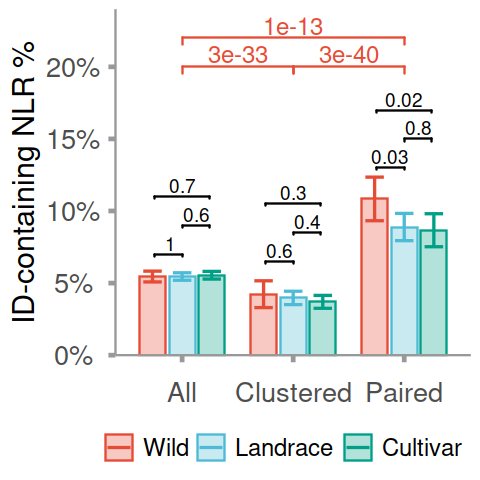

In [40]:
# plot section 
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              complete = TRUE,
#               axis.text.x = element_blank(),
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 10, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 5, b = 0, l = 0)),
              legend.title = element_blank(),
#               legend.position = c(0.87,0.9),
              legend.position = "bottom",
              legend.justification = "right",
              legend.text = element_text(size = 14),
              legend.text.align = 0,
#               legend.position = "none")
             )
}

# sig annotation position for status
sig_pos_y = c(0.08, 0.10, 0.12)
sig_pos_x_min = c(0.75,1,0.75)
sig_pos_x_max = c(1,1.25,1.25)

# sig annotation position for status
sig_pos_Y = c(0.23, 0.23, 0.25)
sig_pos_X_min = c(1,2,1)
sig_pos_X_max = c(2,3,3)

options(repr.plot.width = 4, repr.plot.height = 4)
p <- ggplot(data, aes(c_type, domain_percent, fill=Status, color=Status)) +
    stat_summary(fun="mean", 
                 geom="col", 
                 alpha=0.3, 
                 width=0.7, 
                 position = position_dodge(0.8)
                ) + 
    stat_summary(fun.data = mean_cl_normal, 
                 geom = "errorbar",
                 width=0.5, 
                 position = position_dodge(0.8),
                 size=0.7) +      
     ylab("ID-containing NLR %")+
     theme_custom() +
     scale_fill_npg() +
     scale_color_npg() +
     scale_y_continuous(limits=c(0,0.24), n.breaks=6,
                        oob = rescale_none,
                        expand = c(0, 0),
                        labels=percent_format(accuracy = 1)) +
     geom_signif(y_position=sig_pos_y-0.01 , color='black',
                xmin=sig_pos_x_min, xmax=sig_pos_x_max, tip_length=0.01,
                annotation=formatC(c( sig_lw[1], sig_cl[1], sig_cw[1]), digits=1)) +
     geom_signif(y_position=sig_pos_y - 0.015, color='black',
                xmin=sig_pos_x_min + 1 , xmax=sig_pos_x_max +1 , tip_length=0.01,
                annotation=formatC(c(sig_lw[2], sig_cl[2], sig_cw[2]), digits=1)) +
     geom_signif(y_position=sig_pos_y + 0.05, color='black',
                xmin=sig_pos_x_min +2 , xmax=sig_pos_x_max +2 , tip_length=0.01,
                annotation=formatC(c(sig_lw[3], sig_cl[3], sig_cw[3]), digits=1)) +
     geom_signif(y_position=sig_pos_Y-0.03, textsize=5,
                xmin=sig_pos_X_min, xmax=sig_pos_X_max, tip_length=0.03,
                annotation=formatC(c(all_vs_clu, clu_vs_pir, all_vs_pir), digits=1))
p

### Figure 4
The size and diversity of OGs in rice pan-NLRome underwent dramatic changes during domestication.

#### A

In [41]:
# input data
require(ggsankey)
input <- df[c('Status', 'HOG', 'New2_NLR_arch')]

lrr_status <- c()
for (i in input$New2_NLR_arch){
    if (grepl("L", i)){
        lrr_status <- append(lrr_status, "Yes")
    } else {
        lrr_status <- append(lrr_status, "No")
    }
}

input$with_lrr <- lrr_status

generate_input <- function(df, status){
    input_tmp <- input[input['Status']==status,]
    HOG_ID <- input_tmp$HOG %>% unique()
    HOG_status <- c()
    for (i in HOG_ID){
        with_lrr_list <- input_tmp[input_tmp$HOG == i,]$with_lrr
        if (("Yes" %in% with_lrr_list) & ("No" %in% with_lrr_list)){
            HOG_status <- append(HOG_status, "Mixed")
        } else if (("Yes" %in% with_lrr_list) & !("No" %in% with_lrr_list)){
            HOG_status <- append(HOG_status, "LRR")
        } else if (!("Yes" %in% with_lrr_list) & ("No" %in% with_lrr_list)){
            HOG_status <- append(HOG_status, "nLRR")
        }
    }

    df_result <- list("HOG"=HOG_ID, "HOG_status"=HOG_status) %>% as.data.frame
    df_result$Status <- status
    return(df_result)
}

input_cult <- generate_input(input, "Cultivar")
input_land <- generate_input(input, "Landrace")
input_wild <- generate_input(input, "Wild")

# generate sankey input
tmp <- merge(merge(input_cult,input_land, by='HOG', all=TRUE), 
             input_wild, 
             by='HOG', 
             all=TRUE)

tmp1 <- tmp[c('HOG_status.x', 'HOG_status','HOG_status.y')]
colnames(tmp1) <- c('Cultivar', 'Wild', 'Landrace')
sankey_input <- tmp1 %>% make_long(Landrace, Wild, Cultivar)
# drop NA rows
sankey_input <- sankey_input[rowSums(is.na(sankey_input[ , 2]))==0,]

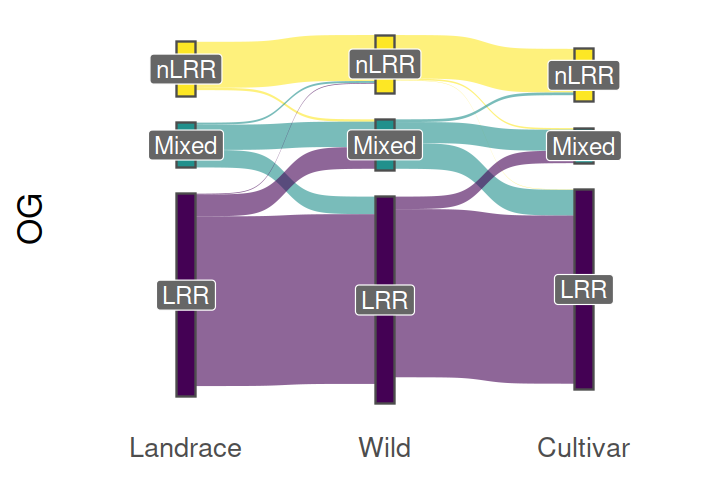

In [42]:
# plot section
options(repr.plot.width = 6, repr.plot.height = 4)
p <- ggplot(sankey_input, aes(x = x, next_x = next_x, node = node, next_node = next_node, fill = factor(node), label = node)) +
  geom_sankey(flow.alpha = .6,
              node.color = "gray30") +
  geom_sankey_label(size = 5, color = "white", fill = "gray40") +
  scale_fill_viridis_d() +
#   scale_fill_npg() +
  theme_sankey(base_size = 20) +
    ylab("OG") +
  labs(x = NULL) +
  theme(legend.position = "none",
        plot.title = element_text(hjust = .5))
p

#### B
- calculate the NLR number difference for nine types of HOG
$$
diff={({HOG\_AVE_{Dome} - HOG\_AVE_{Wild}})} {\frac {Total\_HOG\_NLR}{Total\_NLR}}
$$
where $$HOG\_AVE$$ means the average number of NLR genes per accession for a given HOG type for domesticated or wild group.
$$Total\_HOG\_NLR$$ means the total NLR gene number of a given HOG type
$$Total\_NLR$$ means the total NLR gene number in the rice pan-NLRome


In [43]:
 # input data
input <- df[!is.na(df$HOG_class),] %>%
    group_by(Status, Assembly_ID, with_lrr, HOG_class) %>% 
    summarise_at(vars(gene_ID), list(length))

##### LRR-NLR change
###### LRR-NLR wild - cultivar

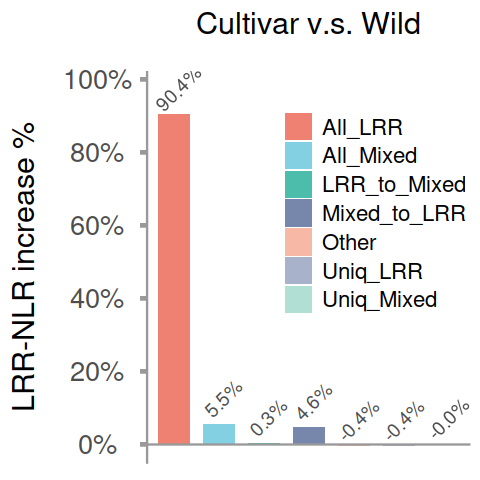

In [44]:
# input for LRR-NLR change
total_num <- df[!is.na(df$HOG_class),]$gene_ID %>% length()

hog_list <- c()
ratio_list <- c()
result_cw <- c()
result_lw <- c()
input_lrr <- input[input$with_lrr == 'LRR', ]
for (i in input_lrr$HOG_class %>% unique()){
    hog_list <- append(hog_list, i)
    
    hog_num <- input[input$HOG_class==i,]$gene_ID %>% sum()
    ratio <- hog_num / total_num
    ratio_list <- append(ratio_list, ratio)
    
    ave_cult <- input_lrr[(input_lrr$HOG_class==i)&(input_lrr$Status == "Cultivar"),]$gene_ID %>% mean()
    ave_land <- input_lrr[(input_lrr$HOG_class==i)&(input_lrr$Status == "Landrace"),]$gene_ID %>% mean()
    ave_wild <- input_lrr[(input_lrr$HOG_class==i)&(input_lrr$Status == "Wild"),]$gene_ID %>% mean()
    
    # replace NA with 0
    ave_list <- c()
    for (y in c(ave_cult, ave_land, ave_wild)){
        if (y %>% is.na()){
            ave_list <- append(ave_list, 0)
        }else{
            ave_list <- append(ave_list, y)
        }
    }

    diff_cw <- (ave_list[1] - ave_list[3]) * ratio
    diff_lw <- (ave_list[2] - ave_list[3]) * ratio
    
    result_cw <- append(result_cw, diff_cw)
    result_lw <- append(result_lw, diff_lw)
}

df_result <- as.data.frame(hog_list)
df_result$ratio <- ratio_list
df_result$diff_cw <- result_cw
df_result$diff_lw <- result_lw

# reshape data
df_result$fraction <- df_result$diff_cw / sum(df_result$diff_cw)
df_result$ymax <- cumsum(df_result$fraction)
df_result$ymin = c(0, head(df_result$ymax, n=-1))

suppressMessages(require(ggbreak))
percent <- function(x, digits = 2, format = "f", ...) {      # Create user-defined function
  paste0(formatC(x * 100, format = format, digits = digits, ...), "%")
}

# plot section
options(repr.plot.width = 4, repr.plot.height = 4)

theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(plot.title = element_text(size=18, margin = margin(t = 0, r = 0, b = 20, l = 0)),
              panel.border = element_blank(), 
              panel.grid.major.y = element_blank(), 
              panel.grid.major.x = element_blank(),               
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
#               axis.line.x = element_blank(),
              axis.line.x.bottom = element_line(size=0), 
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              axis.ticks.x = element_blank(), 
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "grey60", size = rel(2)), 
              strip.text.x = element_text(size=9, color='grey30'),
              complete = TRUE,
              axis.text.x = element_blank(),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 15, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.7,.65),
#               legend.position = "none",           
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 13),
              legend.text.align = 0,
              legend.background = element_rect(color = "transparent" ,fill = "transparent")
             )
}

ggplot(df_result, aes(hog_list, fraction, fill=hog_list)) +
    ggtitle("Cultivar v.s. Wild") +
    geom_col(width=0.7, alpha=0.7) +
    geom_hline(yintercept=0, color='grey60', size =0.5) +
    geom_text(aes(x=hog_list, y=fraction + 0.07), label=df_result$fraction %>% percent(1), angle=45, color="grey30", nudge_x=0.1) +
     scale_y_continuous(n.breaks=6, labels=percent_format(accuracy = 1)) +
    ylab(expression(paste("LRR-NLR increase %"))) +
  scale_fill_npg() +
  theme_custom() 

###### LRR-NLR wild - landrace

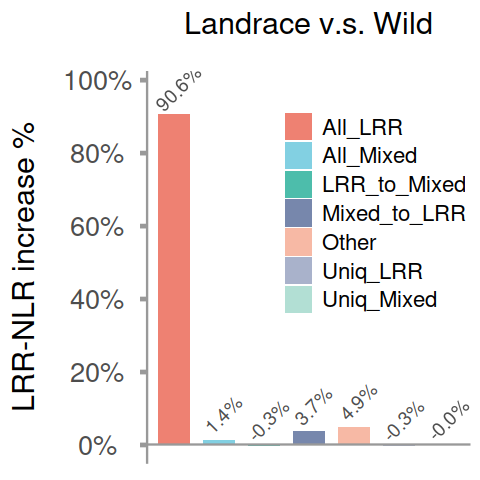

In [45]:
# reshape data
df_result$fraction <- df_result$diff_lw / sum(df_result$diff_lw)
df_result$ymax <- cumsum(df_result$fraction)
df_result$ymin = c(0, head(df_result$ymax, n=-1))

suppressMessages(require(ggbreak))
percent <- function(x, digits = 2, format = "f", ...) {      # Create user-defined function
  paste0(formatC(x * 100, format = format, digits = digits, ...), "%")
}

# plot section
options(repr.plot.width = 4, repr.plot.height = 4)

theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(plot.title = element_text(size=18, margin = margin(t = 0, r = 0, b = 20, l = 0)),
              panel.border = element_blank(), 
              panel.grid.major.y = element_blank(), 
              panel.grid.major.x = element_blank(),               
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
#               axis.line.x = element_blank(),
              axis.line.x.bottom = element_line(size=0), 
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              axis.ticks.x = element_blank(), 
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "grey60", size = rel(2)), 
              strip.text.x = element_text(size=9, color='grey30'),
              complete = TRUE,
              axis.text.x = element_blank(),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 15, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.7,.65),
#               legend.position = "none",           
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 13),
              legend.text.align = 0,
              legend.background = element_rect(color = "transparent" ,fill = "transparent")
             )
}

ggplot(df_result, aes(hog_list, fraction, fill=hog_list)) +
    ggtitle("Landrace v.s. Wild") +
    geom_col(width=0.7, alpha=0.7) +
    geom_hline(yintercept=0, color='grey60', size =0.5) +
    geom_text(aes(x=hog_list, y=fraction + 0.07), label=df_result$fraction %>% percent(1), angle=45, color="grey30", nudge_x=0.1) +
     scale_y_continuous(n.breaks=6, labels=percent_format(accuracy = 1)) +
    ylab(expression(paste("LRR-NLR increase %"))) +
  scale_fill_npg() +
  theme_custom() 

##### nLRR-NLR change
###### nLRR-NLR  wild - cultivar

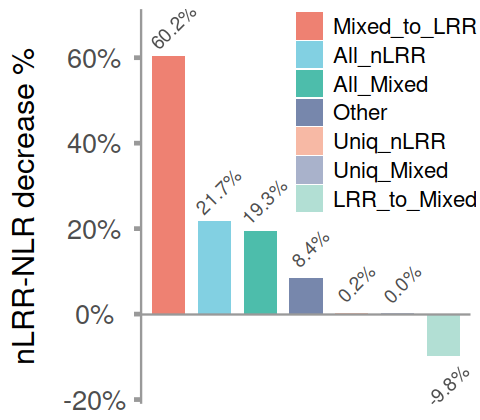

In [46]:
# input data for nLRR-NLR change
total_num <- df[!is.na(df$HOG_class),]$gene_ID %>% length()

hog_list <- c()
ratio_list <- c()
result_cw <- c()
result_lw <- c()
input_lrr <- input[input$with_lrr == 'nLRR', ]
for (i in input_lrr$HOG_class %>% unique()){
    hog_list <- append(hog_list, i)
    
    hog_num <- input[input$HOG_class==i,]$gene_ID %>% sum()
    ratio <- hog_num / total_num
    ratio_list <- append(ratio_list, ratio)
    
    ave_cult <- input_lrr[(input_lrr$HOG_class==i)&(input_lrr$Status == "Cultivar"),]$gene_ID %>% mean()
    ave_land <- input_lrr[(input_lrr$HOG_class==i)&(input_lrr$Status == "Landrace"),]$gene_ID %>% mean()
    ave_wild <- input_lrr[(input_lrr$HOG_class==i)&(input_lrr$Status == "Wild"),]$gene_ID %>% mean()
    
    
    # replace NA with 0
    ave_list <- c()
    for (y in c(ave_cult, ave_land, ave_wild)){
        if (y %>% is.na()){
            ave_list <- append(ave_list, 0)
        }else{
            ave_list <- append(ave_list, y)
        }
    }
    
    diff_cw <- (ave_list[3] - ave_list[1]) * ratio
    diff_lw <- (ave_list[3] - ave_list[2]) * ratio
    
    result_cw <- append(result_cw, diff_cw)
    result_lw <- append(result_lw, diff_lw)
}

df_result <- as.data.frame(hog_list)
df_result$ratio <- ratio_list
df_result$diff_cw <- result_cw
df_result$diff_lw <- result_lw

# reshape data
df_result$fraction <- df_result$diff_cw / sum(df_result$diff_cw)
df_result$ymax <- cumsum(df_result$fraction)
df_result$ymin = c(0, head(df_result$ymax, n=-1))
df_result$hog_list <- factor(df_result$hog_list, df_result %>% arrange(desc(fraction)) %>% .$hog_list)

suppressMessages(require(ggbreak))
percent <- function(x, digits = 2, format = "f", ...) {      # Create user-defined function
  paste0(formatC(x * 100, format = format, digits = digits, ...), "%")
}

# plot section
options(repr.plot.width = 4, repr.plot.height = 3.5)
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major.y = element_blank(), 
              panel.grid.major.x = element_blank(),               
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
#               axis.line.x = element_blank(),
              axis.line.x.bottom = element_line(size=0), 
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              axis.ticks.x = element_blank(), 
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "grey60", size = rel(2)), 
              strip.text.x = element_text(size=9, color='grey30'),
              complete = TRUE,
              axis.text.x = element_blank(),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 15, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.74,.75),
#               legend.position = "none",           
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 13),
              legend.text.align = 0,
              legend.background = element_rect(color = "transparent" ,fill = "transparent")
             )
}

ggplot(df_result, aes(hog_list, fraction, fill=hog_list)) +
    geom_col(width=0.7, alpha=0.7) +
    geom_hline(yintercept=0, color='grey60', size =0.5) +
    geom_text(aes(x=hog_list, y= (abs(fraction) + 0.07)*(fraction/abs(fraction))), label=df_result$fraction %>% percent(1), angle=45, color="grey30", nudge_x=0.1) +
     scale_y_continuous(n.breaks=6, labels=percent_format(accuracy = 1)) +
    ylab(expression(paste("nLRR-NLR decrease %"))) +
  scale_fill_npg() +
  theme_custom() 

###### nLRR-NLR  wild - landrace

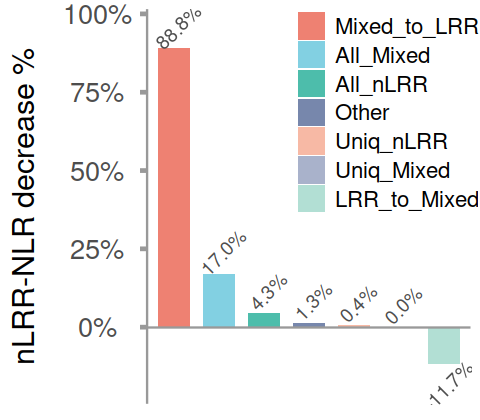

In [47]:
# reshape data
df_result$fraction <- df_result$diff_lw / sum(df_result$diff_lw)
df_result$ymax <- cumsum(df_result$fraction)
df_result$ymin = c(0, head(df_result$ymax, n=-1))
df_result$hog_list <- factor(df_result$hog_list, df_result %>% arrange(desc(fraction)) %>% .$hog_list)

suppressMessages(require(ggbreak))
percent <- function(x, digits = 2, format = "f", ...) {      # Create user-defined function
  paste0(formatC(x * 100, format = format, digits = digits, ...), "%")
}

# plot section
options(repr.plot.width = 4, repr.plot.height = 3.5)
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major.y = element_blank(), 
              panel.grid.major.x = element_blank(),               
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
#               axis.line.x = element_blank(),
              axis.line.x.bottom = element_line(size=0), 
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              axis.ticks.x = element_blank(), 
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "grey60", size = rel(2)), 
              strip.text.x = element_text(size=9, color='grey30'),
              complete = TRUE,
              axis.text.x = element_blank(),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 15, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.74,.75),
#               legend.position = "none",           
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 13),
              legend.text.align = 0,
              legend.background = element_rect(color = "transparent" ,fill = "transparent")
             )
}

ggplot(df_result, aes(hog_list, fraction, fill=hog_list)) +
    geom_col(width=0.7, alpha=0.7) +
    geom_hline(yintercept=0, color='grey60', size =0.5) +
    geom_text(aes(x=hog_list, y= (abs(fraction) + 0.07)*(fraction/abs(fraction))), label=df_result$fraction %>% percent(1), angle=45, color="grey30", nudge_x=0.1) +
     scale_y_continuous(n.breaks=6, labels=percent_format(accuracy = 1)) +
    ylab(expression(paste("nLRR-NLR decrease %"))) +
  scale_fill_npg() +
  theme_custom() 


#### C

In [48]:
# generate input df
generate_input <- function(df, hog_type){
input <- df[(df$HOG_class==hog_type)&(!is.na(df$HOG_class)),][c('HOG_class', 
                                                                 'gene_ID', 
                                                                 'HOG', 
                                                                 'Status', 
                                                                 'Assembly_ID')]

input_1 <- input %>% group_by(Status, HOG) %>% 
            summarise_at(vars(gene_ID), list(length))

acc_num <- input[c('HOG_class', 'HOG', 'Status', 'Assembly_ID')] %>% 
            unique() %>% 
            group_by(Status, HOG) %>% 
            summarise_at(vars(Assembly_ID), list(length))

input_2 <- merge(input_1, acc_num, by=c("Status", "HOG"), all.x=TRUE)

input_2$ave_num <- input_2$gene_ID/input_2$Assembly_ID
return(input_2)
}

input <- generate_input(df, "All_LRR")
increase_hog <- input[(input$Status == 'Cultivar')&(input$ave_num >1.5),]$HOG
# order stauts
input$Status <- factor(input$Status, levels=c("Wild", "Landrace", "Cultivar"))

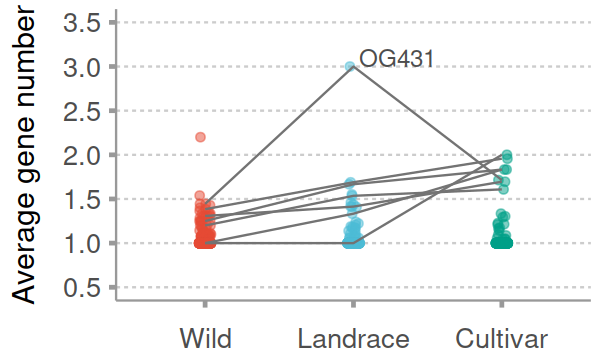

In [49]:
# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major.y = element_line(colour = "gray80", size = 0.5, linetype="dashed"), 
              panel.grid.major.x = element_blank(),               
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "grey60", size = rel(2)), 
              strip.text.x = element_text(size=9, color='grey30'),
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 10, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 15, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.8,0.9),
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0,
              legend.background = element_rect(color = "transparent" ,fill = "transparent")
             )
}

options(repr.plot.width = 5, repr.plot.height = 3)
p <- ggplot(input, aes(Status,ave_num, fill=Status, color=Status)) +
     geom_jitter(size=2,
                 alpha=0.5,
                 width=0.04,
                 show.legend=FALSE) + 
#     geom_line(data=test[test$HOG %in% decrease_hog,],
#               aes(x=Status, y=ave_num, group=HOG),
#               color="#595FFF", size=0.5, alpha=0.5, linetype=1) +
    geom_line(data=input[input$HOG %in% increase_hog,],
              aes(x=Status, y=ave_num, group=HOG),
              color="#737373", size=0.5, alpha=1, linetype=1) +
    annotate(geom="text", label="OG431", x=2.3, y=3.1, color="grey30", size=5) +
     ylab("Average gene number")+
     theme_custom() +
     scale_fill_npg() +
     scale_color_npg() +
     scale_y_continuous(limits=c(0.5, 3.5), n.breaks=8)
p

#### D

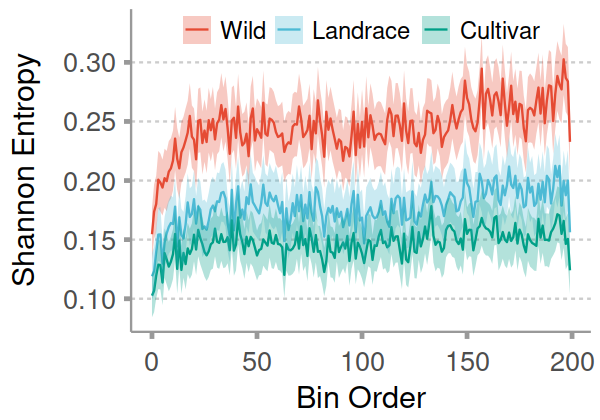

In [50]:
# input shannon entropy data
df_ent <- read.csv(paste0(data_path, "average_entropy.tab"),
               sep="\t", header=TRUE, stringsAsFactors=FALSE)

# calculate mean Entropy and CI for each bin of three status
create_data <- function(df, Status){
    bin_vec <- c()
    mean_vec <- c()
    up_vec <- c()
    low_vec <- c()
    for (i in 0:199){
    ent_vec <- df[df$Bin.Order==i & df$Status==Status,]$Entropy
#     ent_vec <- ent_vec[ent_vec != 0] # remove 0
        m <- mean(ent_vec) # average
        s <- sd(ent_vec)
        n <- length(ent_vec)
        error <- qnorm(0.95)*s/sqrt(n)
        low <- m-error # CI left
        up <- m+error # CI right
    bin_vec <- append(bin_vec, i)
    mean_vec <- append(mean_vec, m)
    low_vec <- append(low_vec, low)
    up_vec <- append(up_vec, up)
}
    df_out <- data.frame(bin_vec, mean_vec, low_vec, up_vec)
    return(df_out)
}

df_cult <- create_data(df_ent, "Cultivar")
df_land <- create_data(df_ent, "Landrace")
df_wild <- create_data(df_ent, "Wild")

df_cult$status = 'Cultivar'
df_land$status = 'Landrace'
df_wild$status = 'Wild'
df_int <- rbind(df_cult, df_land, df_wild)
df_int$status <- factor(df_int$status, levels=c("Wild", "Landrace", "Cultivar"))

# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major.y = element_line(colour = "gray80", size = 0.5, linetype="dashed"), 
              panel.grid.major.x = element_blank(),               
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "grey60", size = rel(2)), 
              strip.text.x = element_text(size=9, color='grey30'),
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 5, r = 0, b = 5, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_text(size=18, angle=0, margin = margin(t = 0, r = 15, b = 0, l = 0)),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 15, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.5,0.95),
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0,
              legend.background = element_rect(color = "transparent" ,fill = "transparent")
             )
}

options(repr.plot.width = 5, repr.plot.height = 3.5)
p <- ggplot(df_int, aes(bin_vec, mean_vec))
p + geom_line(aes(bin_vec, mean_vec, color=status)) +
    geom_ribbon(aes(ymin=low_vec, ymax=up_vec, fill=status), alpha=0.3) +
    scale_fill_npg() +
    scale_color_npg() +
    ylab("Shannon Entropy")+
    xlab("Bin Order")+
    theme_custom()+
    guides(fill = guide_legend(nrow = 1))

#### E

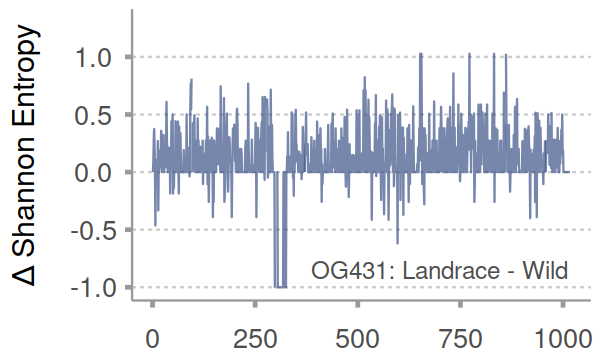

In [51]:
# input data
ent_431 <- read.csv(paste0(data_path, "HOG0000431_entropy_table.csv"),
               sep=",", header=TRUE, stringsAsFactors=FALSE)

input <- ent_431[c('AA_order', 'ent_ng_L2W')]

# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major.y = element_line(colour = "gray80", size = 0.5, linetype="dashed"), 
              panel.grid.major.x = element_blank(),               
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "grey60", size = rel(2)), 
              strip.text.x = element_text(size=9, color='grey30'),
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 10, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 15, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.8,0.9),
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0,
              legend.background = element_rect(color = "transparent" ,fill = "transparent")
             )
}

options(repr.plot.width = 5, repr.plot.height = 3)
p <- ggplot(input, aes(AA_order, ent_ng_L2W))
p + geom_line(color="#3C5488B2") +
    scale_y_continuous(limits=c(-1,1.3)) +
    ylab(expression(paste("\u394", " Shannon Entropy")))+
    annotate(geom="text", label="OG431: Landrace - Wild", x=700, y=-0.85, color="grey30", size=5) +
    theme_custom()

#### F

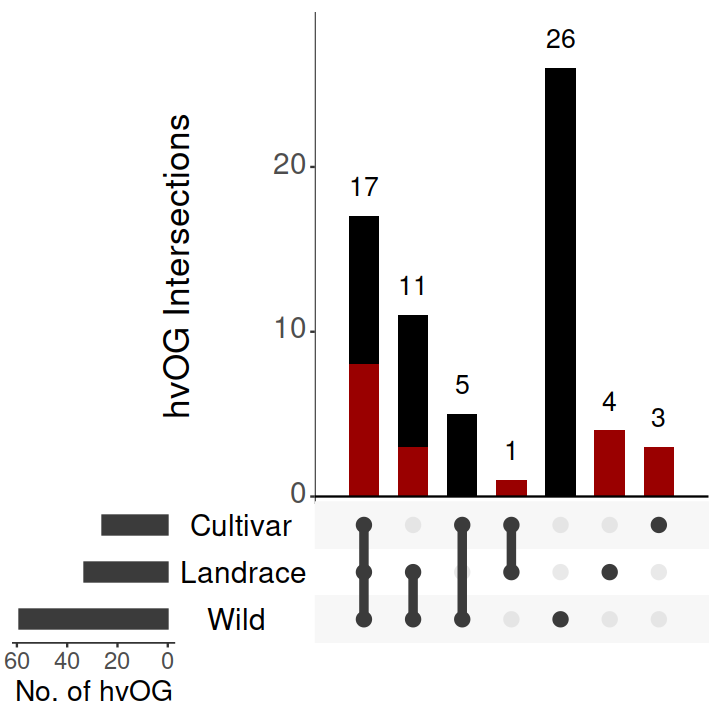

In [52]:
# input hvSite data
df_hv <- read.csv(paste0(data_path, "hvNLR_thresh5.tab"),
               sep="\t", header=TRUE, stringsAsFactors=FALSE)

# tidy up 
df_hv[df_hv ==  "-"] <- 0
tmp <- df_hv[c('Cultivar', 'Landrace', 'Wild')] %>% mutate_if(is.character,as.numeric)
df_hv <- cbind(df_hv[c('HOG')], tmp)

# mark HOGs whose HV site in dome is higher than wild 
dome_gtr_wild <- c()
for (i in 1:70){
if (df_hv$Cultivar[i] > df_hv$Wild[i] | df_hv$Landrace[i] > df_hv$Wild[i]){
    dome_gtr_wild <- append(dome_gtr_wild, "dome_gtr_wild")
} else{
    dome_gtr_wild <- append(dome_gtr_wild, "wild_gtr_dome")
}
}

df_hv$gtr_hog <- dome_gtr_wild

# generate input df for upsetR
tmp2 <- df_hv[c('Cultivar', 'Landrace', 'Wild')]
tmp2[tmp2>0] <- 1
input <- cbind(df_hv[c('HOG', 'gtr_hog')], tmp2)

select_hog <- function(row, id){
    newData <- (row["gtr_hog"] == id)
}

# plot section
options(repr.plot.width = 6, repr.plot.height = 6)
upset(input, 
      sets=c("Cultivar", "Landrace", "Wild"),
      order.by = c("freq", "degree"), 
      decreasing = c(TRUE,TRUE),
      point.size = 4, 
      line.size = 2, 
      mainbar.y.label = "hvOG Intersections",
       mainbar.y.max=28,
      sets.x.label = "No. of hvOG", 
      mb.ratio = c(0.7, 0.3),
      text.scale = c(2.5, 2.5, 2, 2, 2.5, 2.5), 
      main.bar.color = "black",
      queries=list(list(query=select_hog, params=c("dome_gtr_wild"), color='#DC0000B2', active=TRUE)))

### Figure 5
Diversity and specificity of integrated domains (IDs) within rice NLRs.

#### A

In [53]:
# input data
df_domain <- read.csv(paste0(data_path, "01.rice_NLRome_domain_info_31Mar2021.tab"),
                header=TRUE,
                stringsAsFactors=FALSE,
                quote="",
                sep="\t")

# join "Status" "Accession" and "Specie" info
df_ID <- merge(df_domain,
              df[,c('gene_ID', 'Assembly_ID', 'Status', 'Species')],
              by='gene_ID', 
              all.x=TRUE)  %>% 
              drop_na() %>% 
              subset(short_domain == 'X')

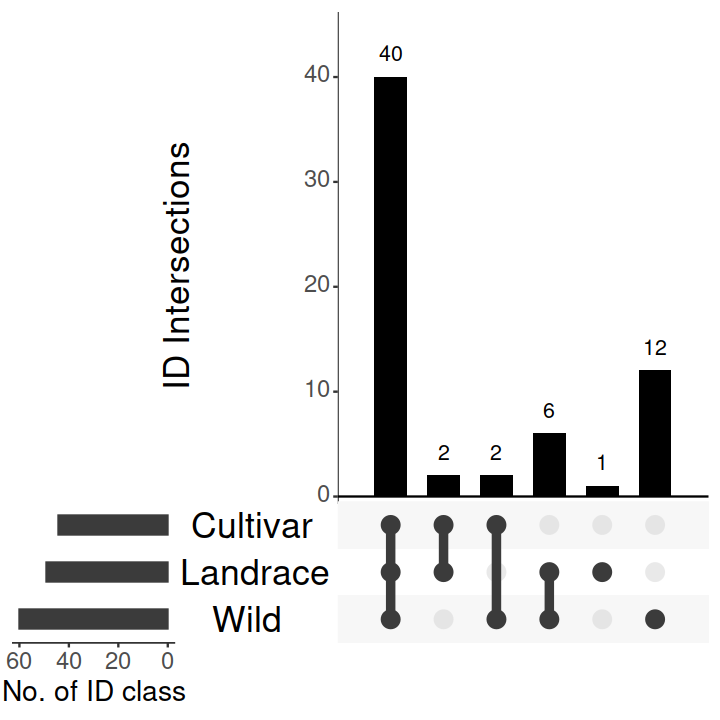

In [54]:
# plot section
status_input <- list(
Cultivar = df_ID[df_ID$Status == 'Cultivar', 'domain'] %>% unique(),
Landrace = df_ID[df_ID$Status == 'Landrace', 'domain'] %>% unique(),
Wild = df_ID[df_ID$Status == 'Wild', 'domain'] %>% unique())

options(repr.plot.width = 6, repr.plot.height = 6)
upset(fromList(status_input), 
      order.by = "degree", 
      point.size = 5, 
      line.size = 2, 
      mainbar.y.label = "ID Intersections", 
      sets.x.label = "No. of ID class", 
      text.scale = c(2.5, 2, 2, 2, 3, 2),
      main.bar.color = "black")

#### B

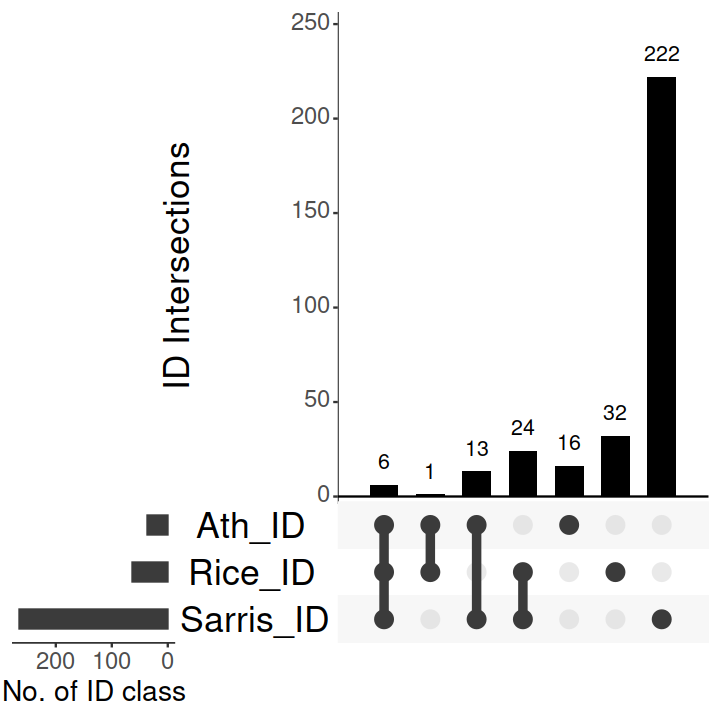

In [55]:
# Cell 2019 paper ID list
dom <- read.csv(paste0(data_path, "SITable-Domains.tsv"),header=TRUE, sep = "\t")
domintCol2 <- dom[which(dom$`Araport11`=='1' & dom$Domain_ID!='TIR' & dom$Domain_ID!='NB' & dom$Domain_ID!='LRR' & dom$Domain_ID!='Coil' & dom$Domain_ID!='RPW8') ,]
domintCol22 <- dom[which(dom$Araport11=='0') ,]
Ath_ID <- rbind(domintCol2, domintCol22)$Pfam_identifier %>% unique() %>% as.vector()

# Sarris et al. ID list
df_sarris <- read.csv(paste0(data_path, "06.Sarris_2016_id.tab"), sep="\t")
Sarris_ID <- df_sarris$Domain %>% unique()  %>% as.vector()

# Rice ID list
Rice_ID <- df_ID$domain %>% unique() %>% as.vector()

species_input <- list(
Rice_ID = df_ID$domain %>% unique() %>% as.vector(),
Ath_ID = rbind(domintCol2, domintCol22)$Pfam_identifier %>% as.vector(),
Sarris_ID = df_sarris$Domain %>% unique() %>% as.vector()
)

options(repr.plot.width = 6, repr.plot.height = 6)
upset(fromList(species_input), 
      order.by = "degree", 
      point.size = 5, 
      line.size = 2, 
      mainbar.y.label = "ID Intersections", 
      sets.x.label = "No. of ID class",
      text.scale = c(2.5, 2, 2, 2, 3, 2),
      main.bar.color = "black")

#### C

In [56]:
# create input data
df_domain <- read.csv(paste0(data_path, "01.rice_NLRome_domain_info_31Mar2021.tab"),
                header=TRUE,
                stringsAsFactors=FALSE,
                quote="",
                sep="\t") 

# join "Status" "Accession" and "Specie" info
df_ID <- merge(df_domain,
              df[,c('gene_ID', 'Assembly_ID', 'Status', 'Species', 'Pair_partner_new')],
              by='gene_ID', 
              all.x=TRUE)  %>% 
              drop_na() %>% 
              subset(short_domain == 'X')

# calculate the IntDomain Number/Accession for every status
df_ID_No <- df_ID %>% 
                group_by(domain, Status) %>% 
                summarise_at(vars(gene_ID), list(length)) 

df_ID_Assembly_No <- df_ID[, c('domain', 'Status', 'Assembly_ID')]  %>% 
                        unique() %>% 
                        group_by(domain, Status) %>% 
                        summarise_at(vars(Assembly_ID), list(length))

df_ID_heatmap = df_ID_No[,c('domain', 'Status', 'gene_ID')] 
df_ID_heatmap$ave_ID_No = df_ID_No$gene_ID / df_ID_Assembly_No$Assembly_ID
colnames(df_ID_heatmap)[3] = 'ID_No'

# calculate the IntDomain Pair Fraction for every status
df_ID_pair <- df_ID[(df_ID$Pair_partner_new != "-"),] %>% 
                    group_by(domain, Status) %>% 
                    summarise_at(vars(Pair_partner_new), list(length))

df_ID_heatmap <- df_ID_heatmap %>% 
                    merge(df_ID_pair, 
                          by=c('domain', 'Status'), 
                          all.x = TRUE)

colnames(df_ID_heatmap)[5] <- 'is_Pair'

df_ID_heatmap$Pair_ratio = df_ID_heatmap$is_Pair / df_ID_heatmap$ID_No


# reorder rows of the input table
freq_list <- c()
for (i in df_ID_heatmap$domain) {
    freq <- table(df_ID_heatmap$domain)[names(table(df_ID_heatmap$domain)) == i]
    freq_list <- append(freq_list, freq)
}

df_ID_heatmap$freq_list = freq_list
# df_ID_heatmap <- df_ID_heatmap %>% arrange(ave_ID_No, freq_list)
df_ID_heatmap <- df_ID_heatmap %>% arrange(ave_ID_No)
df_ID_heatmap <- df_ID_heatmap %>% arrange(freq_list)

# reorder the input table
df_ID_heatmap$domain <- factor(df_ID_heatmap$domain, 
                               levels=unique(df_ID_heatmap$domain))
df_ID_heatmap$Status <- factor(df_ID_heatmap$Status, 
                               levels=c('Wild', 'Landrace', 'Cultivar'))

# creat decimal place text for pair_ratio
Pair_ratio2 = vector()
for (i in df_ID_heatmap$Pair_ratio){
    if (is.na(i)) {
        Pair_ratio2=append(Pair_ratio2, NA)
    } else {
        Pair_ratio2=append(Pair_ratio2, format(round(i, 2), nsmall=2))
    }
}

df_ID_heatmap$Pair_ratio2 <- Pair_ratio2

# split the input data as two parts
ID_list <- unique(df_ID_heatmap$domain)
ID_list1 <- ID_list[32:63]
ID_list2 <- ID_list[1:31]

Warning message:
“Removed 64 rows containing missing values (geom_text).”
Warning message:
“Removed 44 rows containing missing values (geom_text).”


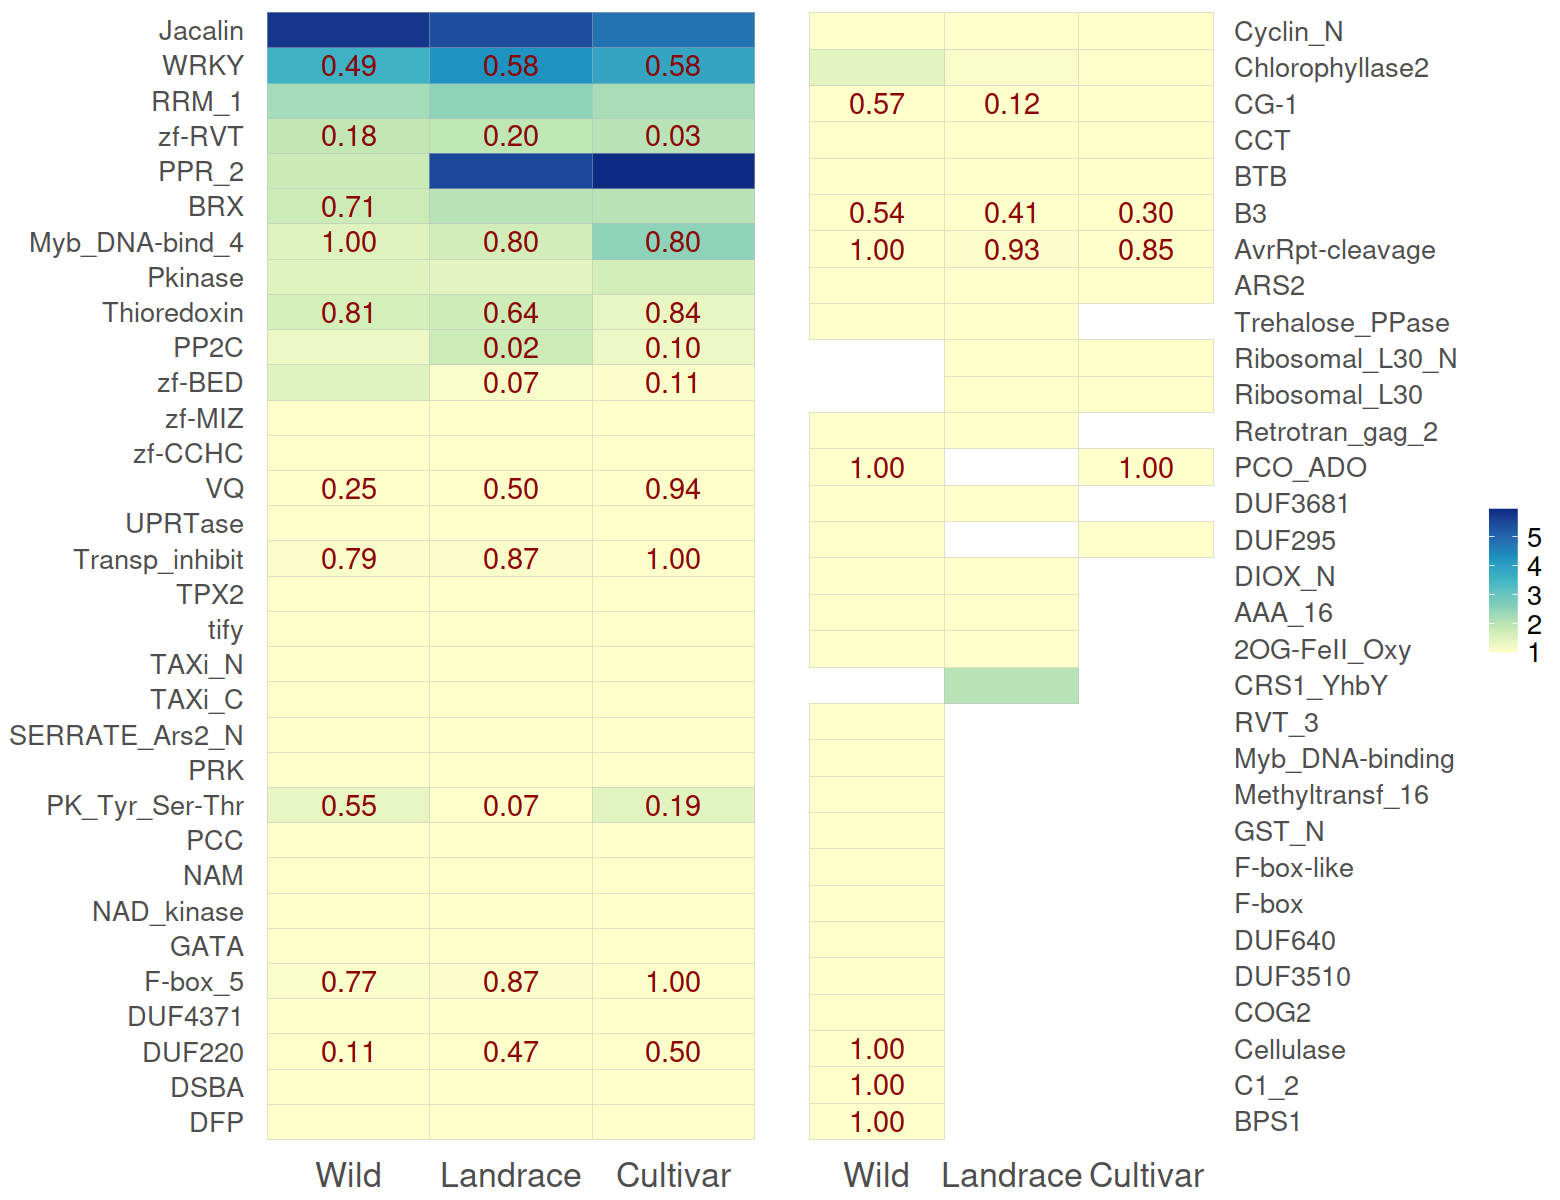

In [57]:
# Plot Heatmap part1
# set theme function 
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22)
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid = element_blank(),
#               axis.line = element_line(colour = "black", size = rel(1)),
              axis.line = element_blank(),
              axis.ticks.length=unit(0.15, "cm"),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              strip.text.x = element_blank(),
              complete = TRUE,
              axis.ticks.x = element_blank(),
              axis.ticks.y = element_blank(),
              axis.text.x = element_text(size=20, angle=0, color="grey30", margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, 
                                         color="grey30",
                                         hjust=1, vjust = 0.5),
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              legend.title = element_blank(),
#               legend.position = c(0.52,0.9),
              legend.position = "bottom",
              legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0
             )
}

options(repr.plot.width = 6, repr.plot.height = 10)
p1 <- ggplot(df_ID_heatmap[df_ID_heatmap$domain %in% ID_list1,], 
       aes(Status, domain, fill= ave_ID_No)) + 
    geom_tile(linetype=1,
              width=1,
              height=1,
              color = 'gray',
              alpha=1,
              show.legend=FALSE)+ 
    geom_text(aes(label = Pair_ratio2), color='darkred', size=6,
              show.legend=FALSE) +
    scale_fill_distiller(palette = "YlGnBu", direction = 1,
                         limits = c(min(df_ID_heatmap$ave_ID_No), max(df_ID_heatmap$ave_ID_No))) +
    theme_custom()

# Plot Heatmap part2
# set theme function 
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid = element_blank(),
#               axis.line = element_line(colour = "black", size = rel(1)),
              axis.line = element_blank(),
              axis.ticks.length=unit(0.15, "cm"),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              strip.text.x = element_blank(),
              complete = TRUE,
              axis.ticks.x = element_blank(),
              axis.ticks.y = element_blank(),
              axis.text.x = element_text(size=20, angle=0, color="grey30", margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.text.y.right = element_text(size=16, 
                                         color="grey30",
                                         hjust=0, vjust = 0.5),
#               axis.text.y.left = element_text(size=16, 
#                                          color="black",
#                                          hjust=1, vjust = 0.5),
              axis.text.y.left = element_blank(),
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              legend.title = element_blank(),
#               legend.position = c(0.52,0.9),
              legend.position = "right",
              legend.justification = "center",
              legend.text = element_text(size = 16),
              legend.text.align = 0
             )
}

#--create sec--#--https://github.com/tidyverse/ggplot2/issues/3171
guide_axis_label_trans <- function(label_trans = identity, ...) {
  axis_guide <- guide_axis(...)
  axis_guide$label_trans <- rlang::as_function(label_trans)
  class(axis_guide) <- c("guide_axis_trans", class(axis_guide))
  axis_guide
}

guide_train.guide_axis_trans <- function(x, ...) {
  trained <- NextMethod()
  trained$key$.label <- x$label_trans(trained$key$.label)
  trained
}

###############
options(repr.plot.width = 7, repr.plot.height = 10)
p2 <- ggplot(df_ID_heatmap[df_ID_heatmap$domain %in% ID_list2,], 
       aes(Status, domain, fill= ave_ID_No)) + 
    geom_tile(linetype=1,
              width=1,
              height=1,
              color = 'gray',
              alpha=1)+ 
    geom_text(aes(label = Pair_ratio2), color='darkred', size=6) +
    scale_fill_distiller(palette = "YlGnBu", direction = 1, 
                         limits = c(min(df_ID_heatmap$ave_ID_No), max(df_ID_heatmap$ave_ID_No))) +
    theme_custom() + 
    guides(y.sec = guide_axis_label_trans(~.x))

options(repr.plot.width = 13, repr.plot.height = 10)
plot_grid(p1, p2) 

#### D

In [58]:
# create input data
# df are the SumTable imported at begining
df_domain <- read.csv(paste0(data_path, "01.rice_NLRome_domain_info_31Mar2021.tab"),
                header=TRUE,
                stringsAsFactors=FALSE,
                quote="",
                sep="\t")

# join "Status" "Accession" and "Specie" info
df_ID <- merge(df_domain,
              df[,c('gene_ID', 'Assembly_ID', 'Status', 'Species')],
              by='gene_ID', 
              all.x=TRUE)  %>% 
              drop_na() %>% # the key step for droping all genes without NB domain
              subset(short_domain == 'X')

df_ID_domain <- df_domain[df_domain$gene_ID %in% (df_ID$gene_ID %>% unique()),]

# create short NLR-ID string, only keep ID as full name and other cononical domains as short
nlr_arch_list <- c()
for (i in unique(df_ID_domain$gene_ID)){
    dm_list <- df_ID_domain[df_ID_domain$gene_ID == i, ]$domain
    sdm_list <- df_ID_domain[df_ID_domain$gene_ID == i, ]$short_domain
    full_arch <- c()
    for (i in 1:length(dm_list)) {
        if (sdm_list[i] != 'X'){
            full_arch <- append(full_arch, sdm_list[i])
        } else if (sdm_list[i] == 'X'){
            full_arch <- append(full_arch, dm_list[i])            
        }
    }
    nlr_arch_list <- append(nlr_arch_list, paste(full_arch, collapse="/"))
}

# drop duplicates in full_arch
nlr_uniq_arch_list <- c()
for (i in unique(df_ID_domain$gene_ID)){
    dm_list <- df_ID_domain[df_ID_domain$gene_ID == i, ]$domain
    sdm_list <- df_ID_domain[df_ID_domain$gene_ID == i, ]$short_domain
    full_arch <- c()
    for (i in 1:length(dm_list)) {
        if (sdm_list[i] != 'X'){
            full_arch <- append(full_arch, sdm_list[i])
        } else if (sdm_list[i] == 'X'){
            full_arch <- append(full_arch, dm_list[i])            
        }
    }
    nlr_uniq_arch_list <- append(nlr_uniq_arch_list, paste(unique(full_arch), collapse="/"))
}


df_arch <- as.data.frame(unique(df_ID_domain$gene_ID))
colnames(df_arch)[1] = "gene_ID"
df_arch$full_arch <- nlr_arch_list
df_arch$uniq_arch <- nlr_uniq_arch_list

df_arch <- merge(df_arch, df[,c('gene_ID', 'HOG', 'Status', 'Species')],
              by='gene_ID', 
              all.x=TRUE)

df_arch_num <- df_arch[!grepl("Feral", df_arch$Status), ] %>% 
                group_by(uniq_arch, Status) %>% 
                summarise_at(vars(gene_ID), list(length))
colnames(df_arch_num)[3] = "arch_num"

df_arch_total_num <- df_arch[!grepl("Feral", df_arch$Status), ] %>% 
                            group_by(uniq_arch) %>% 
                            summarise_at(vars(gene_ID), list(length))
colnames(df_arch_total_num)[2] = "arch_total_num"

df_arch_num_final <- merge(df_arch_num, df_arch_total_num, 
                          by="uniq_arch", all.x = TRUE)

df_arch_num_final <- df_arch_num_final[order(df_arch_num_final$arch_total_num),]

# reorder the input table
df_arch_num_final$uniq_arch <- factor(df_arch_num_final$uniq_arch, 
                               levels=unique(df_arch_num_final$uniq_arch))
df_arch_num_final$Status <- factor(df_arch_num_final$Status, 
                               levels=c('Cultivar', 'Landrace', 'Wild'))

# generate the CLW tag
Status_Mark <- c()
for (i in df_arch_num_final$uniq_arch){
    status_list = df_arch_num_final[df_arch_num_final$uniq_arch == i,]$Status %>% as.vector()    
    status_list = replace(status_list,match("Cultivar", status_list),"C")
    status_list = replace(status_list,match("Landrace", status_list),"L") 
    status_list = replace(status_list, match("Wild", status_list),"W") 
    label = paste0(status_list, collapse="")
    Status_Mark = append(Status_Mark, label)
}

df_arch_num_final$Status_Mark <- Status_Mark

# generate NLR_arch list
arch_list = df_arch_total_num[order(df_arch_total_num$arch_total_num),]$uniq_arch

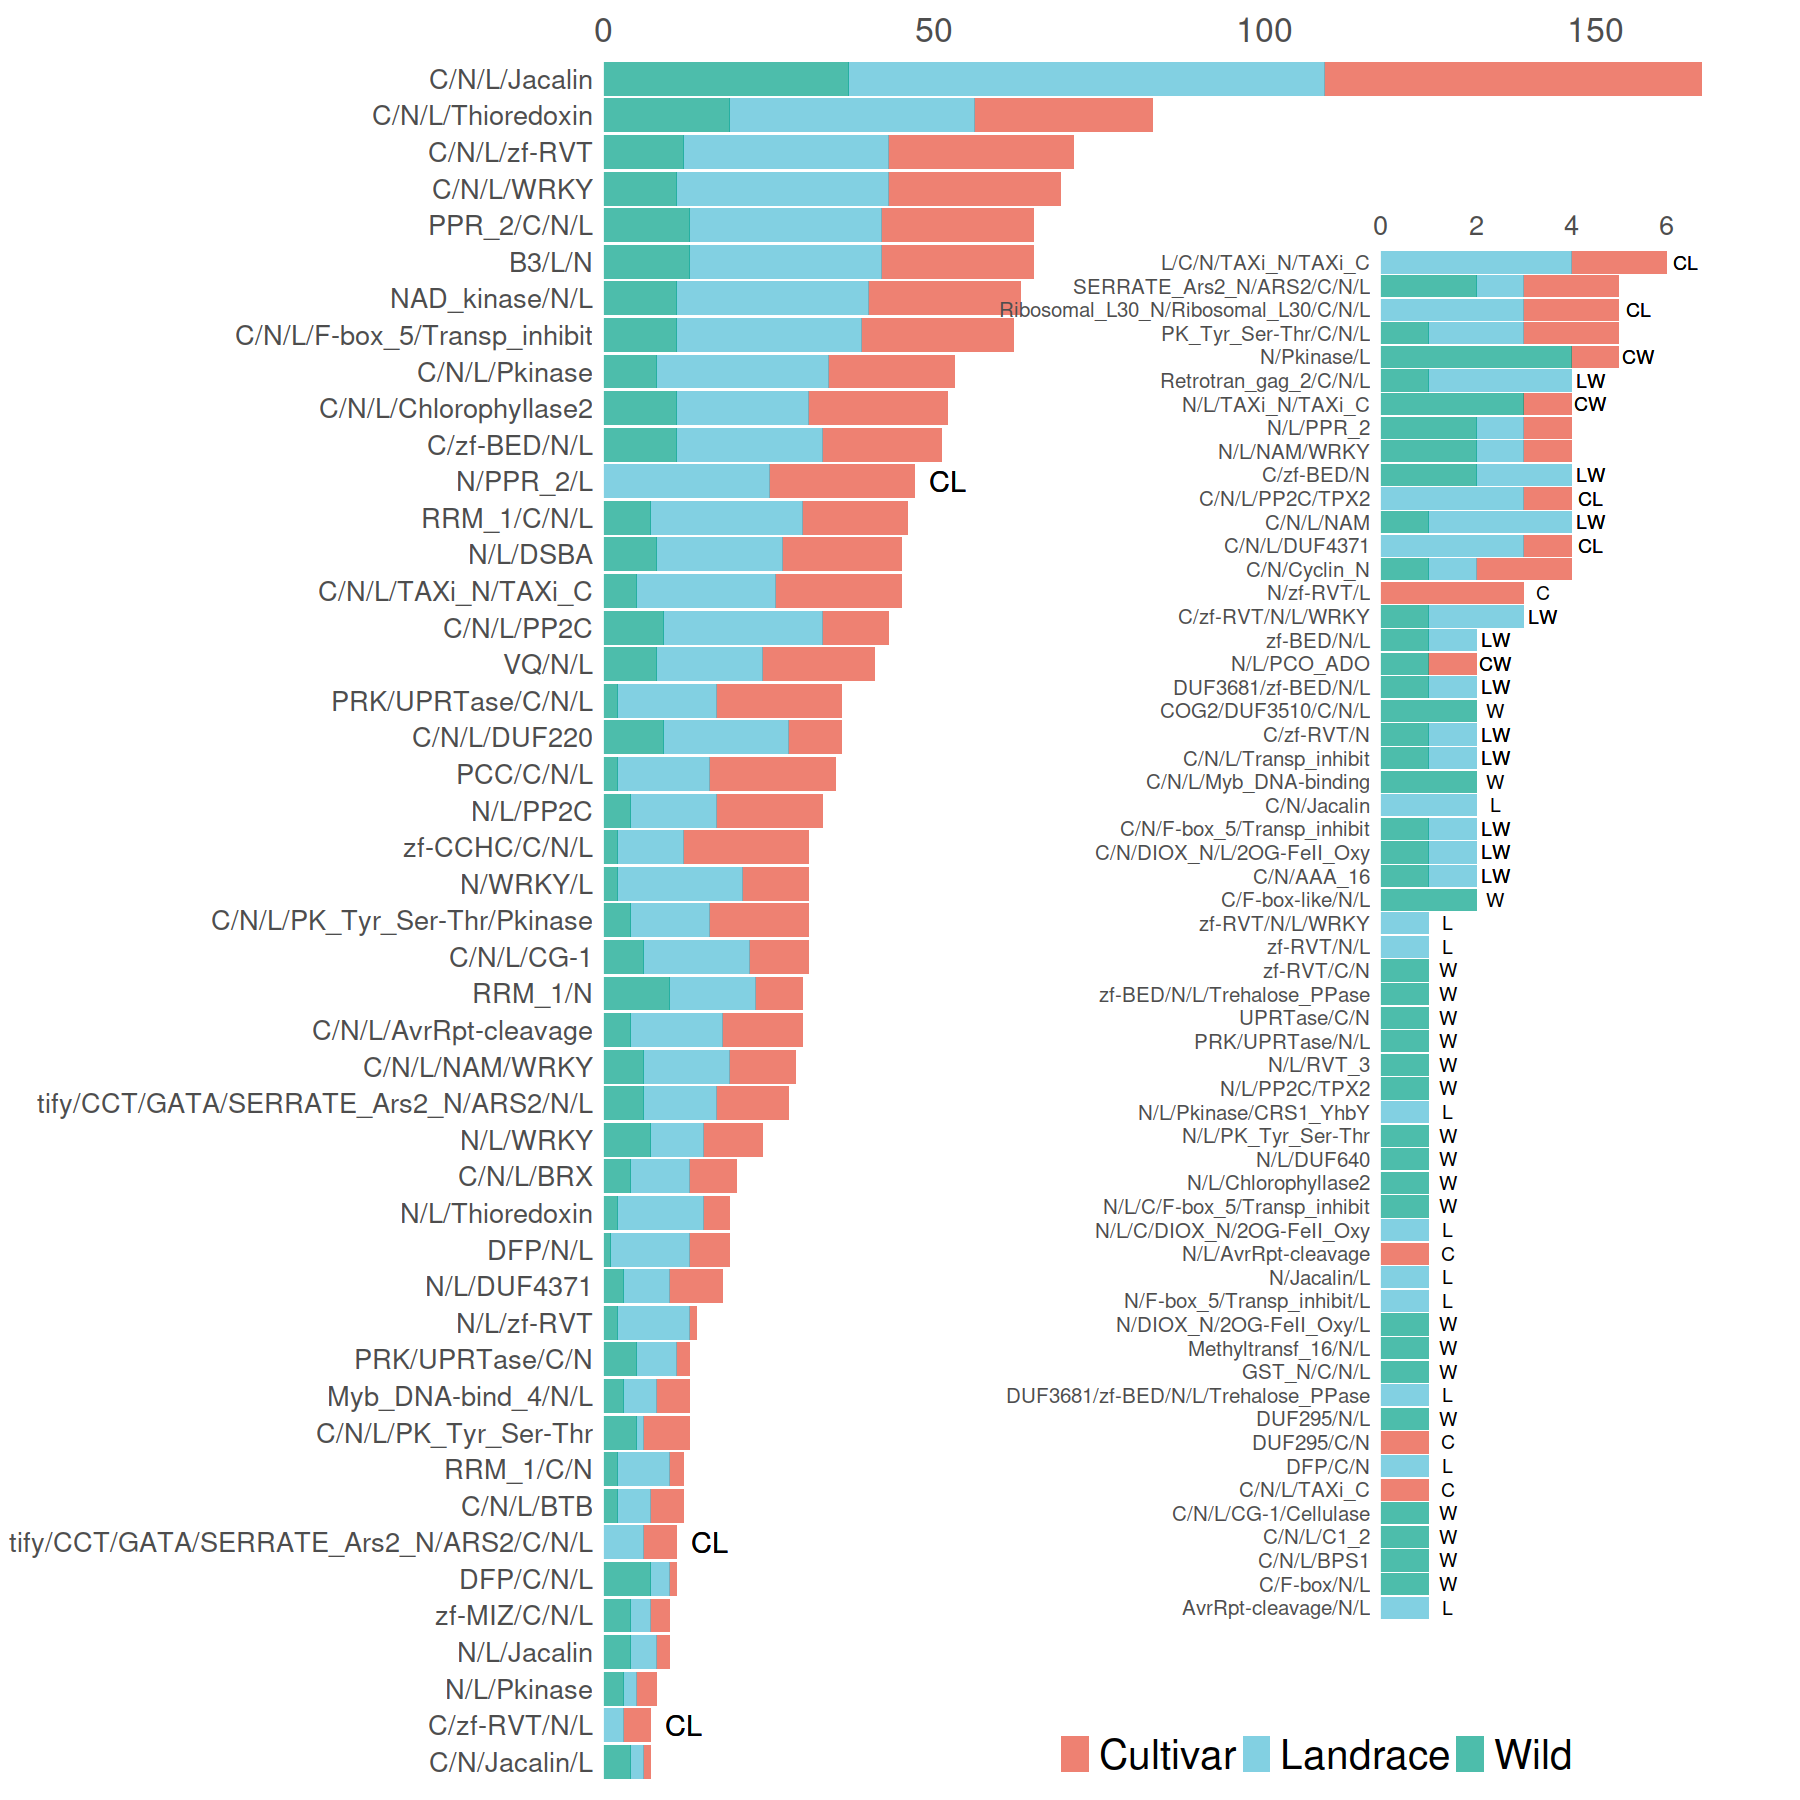

In [59]:
# plot section
options(repr.plot.width = 15, repr.plot.height = 15)

#--create sec--#--https://github.com/tidyverse/ggplot2/issues/3171
guide_axis_label_trans <- function(label_trans = identity, ...) {
  axis_guide <- guide_axis(...)
  axis_guide$label_trans <- rlang::as_function(label_trans)
  class(axis_guide) <- c("guide_axis_trans", class(axis_guide))
  axis_guide
}

guide_train.guide_axis_trans <- function(x, ...) {
  trained <- NextMethod()
  trained$key$.label <- x$label_trans(trained$key$.label)
  trained
}
#------------------------
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid = element_blank(),
#               axis.line.x = element_line(colour = "black", size = rel(1)),
              axis.line.y = element_line(colour = "black", size = rel(1)),
#               axis.line = element_line(colour = "black", size = rel(1)),
#               axis.line = element_blank(),
              axis.ticks.length=unit(0.15, "cm"),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              strip.text.x = element_blank(),
              complete = TRUE,
              axis.ticks.x = element_blank(),
              axis.ticks.y = element_blank(),
              axis.text.x.bottom = element_blank(),
              axis.text.x.top = element_text(size=20, angle=0, color="grey30", margin = margin(t = 5, r = 0, b = 0, l = 0)),
#               axis.text.y.right = element_text(size=14, 
#                                          color="black",
#                                          hjust=0, vjust = 0.5),
              axis.text.y.left = element_text(size=16, 
                                         color="grey30",
                                         hjust=1, vjust = 0.5),
#               axis.text.y.left = element_blank(),
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              legend.title = element_blank(),
              legend.position = c(0.6,0.02),
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 24),
              legend.text.align = 0
             )
}

df_input = df_arch_num_final[df_arch_num_final$uniq_arch %in% arch_list[59:116],]
annot_label = as.vector(df_input$Status_Mark)

p1 <- ggplot(df_input, aes(fill = Status,
                     y = arch_num, 
                     x = uniq_arch))+
        geom_bar(position = "stack", stat = "identity", alpha=0.7)+
        annotate(geom="text",
                 x=df_input$uniq_arch,
                 y=df_input$arch_total_num+5,
                 label=replace(annot_label, annot_label=="CLW", ""),
                 size=6, color="black") +
        scale_y_continuous(expand = expansion(mult = c(0, 0.05)))+
        
        scale_x_discrete(labels=)+

        theme_custom() +
        scale_fill_npg()+
        coord_flip() +
        guides(x.sec = guide_axis_label_trans(~.x)) +
        guides(fill = guide_legend(nrow = 1))


# plotting graph
options(repr.plot.width = 10, repr.plot.height = 10)

#--create sec--#--https://github.com/tidyverse/ggplot2/issues/3171
guide_axis_label_trans <- function(label_trans = identity, ...) {
  axis_guide <- guide_axis(...)
  axis_guide$label_trans <- rlang::as_function(label_trans)
  class(axis_guide) <- c("guide_axis_trans", class(axis_guide))
  axis_guide
}

guide_train.guide_axis_trans <- function(x, ...) {
  trained <- NextMethod()
  trained$key$.label <- x$label_trans(trained$key$.label)
  trained
}
#------------------------
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid = element_blank(),
              panel.background = element_rect(fill = "transparent",colour = NA),
              plot.background = element_rect(fill = "transparent",colour = NA),
#               axis.line.x = element_line(colour = "black", size = rel(1)),
              axis.line.y = element_line(colour = "black", size = rel(1)),
#               axis.line = element_line(colour = "black", size = rel(1)),
#               axis.line = element_blank(),
              axis.ticks.length=unit(0.15, "cm"),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              strip.text.x = element_blank(),
              complete = TRUE,
              axis.ticks.x = element_blank(),
              axis.ticks.y = element_blank(),
              axis.text.x.bottom = element_blank(),
              axis.text.x.top = element_text(size=16, angle=0, color="grey30", margin = margin(t = 5, r = 0, b = 0, l = 0)),
#               axis.text.y.right = element_text(size=14, 
#                                          color="black",
#                                          hjust=0, vjust = 0.5),
              axis.text.y.left = element_text(size=12, 
                                         color="grey30",
                                         hjust=1, vjust = 0.5),
#               axis.text.y.left = element_blank(),
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              legend.title = element_blank(),
#               legend.position = c(0.52,0.9),
              legend.position = "bottom",
              legend.justification = "center",
              legend.text = element_text(size = 24),
              legend.text.align = 0
             )
}

df_input = df_arch_num_final[df_arch_num_final$uniq_arch %in% arch_list[1:58],]
annot_label = as.vector(df_input$Status_Mark)

p2 <- ggplot(df_input, aes(fill = Status,
                     y = arch_num, 
                     x = uniq_arch))+
        geom_bar(position = "stack", stat = "identity", alpha=0.7,show.legend=FALSE)+
        annotate(geom="text",
                 x=df_input$uniq_arch,
                 y=df_input$arch_total_num+0.4,
                 label=replace(annot_label, annot_label=="CLW", ""),
                 size=4, color="black") +
        scale_y_continuous(expand = expansion(mult = c(0, 0.05)))+
        theme_custom() +
        scale_fill_npg()+
        coord_flip() +
        guides(x.sec = guide_axis_label_trans(~.x))

options(repr.plot.width = 15, repr.plot.height = 15)
p <- ggdraw() +
    draw_plot(p1, 0, 0, 1, 1) +
    draw_plot(p2, 0.55, 0.09, 0.4, 0.8)
p

#### E

In [60]:
# create input data
# df are the SumTable imported at begining
df_domain <- read.csv(paste0(data_path, "01.rice_NLRome_domain_info_31Mar2021.tab"),
                header=TRUE,
                stringsAsFactors=FALSE,
                quote="",
                sep="\t")

# join "Status" "Accession" and "Specie" info
df_ID <- merge(df_domain,
              df[,c('gene_ID', 'Assembly_ID', 'Status', 'HOG', 'Species')],
              by='gene_ID', 
              all.x=TRUE)  %>% 
              drop_na() %>% # the key step for droping all genes without NB domain
              subset(short_domain == 'X')

# generate HOG size table
HOG_size <- df %>% group_by(HOG) %>% summarise_at(vars(gene_ID), list(length))
colnames(HOG_size)[2] <- 'HOG_size'

# NLR_ID_to_HOG <- merge(NLR_ID_to_HOG, HOG_size, by='HOG', all.x=TRUE)

# create data for every ID: ID , presented Assemblies, HOG number, NLR-ID proportion in HOGs 
# resented Assemblpies
ID_assembly_number <- df_ID[c('domain', 'Assembly_ID')] %>% 
                            unique %>% 
                            group_by(domain) %>% 
                            summarise_at(vars(Assembly_ID), list(length))
colnames(ID_assembly_number)[2] <- 'Assembly_num'

ID_HOG_number <- df_ID[c('domain', 'HOG')] %>% 
                        unique() %>% 
                        group_by(domain) %>% 
                        summarise_at(vars(HOG), list(length))
colnames(ID_HOG_number)[2] <- 'HOG_number'


# NLR-ID gene percentage in all HOGs
domain <- c()
nlr_id_num <- c()
nlr_num <- c()
nlr_id_percent <- c()

for (i in df_ID$domain %>% unique()){
    NLR_ID_num <- df_ID[df_ID$domain == i,]$gene_ID %>% unique() %>% length() # number of NLR-ID for a certain ID
    hog_list <- df_ID[df_ID$domain == i,]$HOG %>% unique # HOG_list
    NLR_num <- HOG_size[HOG_size$HOG %in% hog_list,]$HOG_size %>% sum # total NLR number
    NLR_ID_percent <- NLR_ID_num/NLR_num
    
    domain <- append(domain, i)
    nlr_id_num <- append(nlr_id_num, NLR_ID_num)
    nlr_num <- append(nlr_num, NLR_num)
    nlr_id_percent <- append(nlr_id_percent, NLR_ID_percent)
}

# generate dataframe
ID_percent <- domain %>% as.data.frame()
ID_percent$NLR_ID_num <- nlr_id_num
ID_percent$NLR_num <- nlr_num
ID_percent$NLR_ID_percent <- nlr_id_percent
colnames(ID_percent)[1]  <- 'domain'

data <- merge(ID_assembly_number, ID_HOG_number, by='domain', all = TRUE) %>% 
    merge(ID_percent, by='domain', all = TRUE)

data$domain <- factor(data$domain, levels = data[order(data$Assembly_num),]$domain)

# creat decimal place text for NLR_ID ratio
NLR_ID_ratio = c()
for (i in data[order(data$Assembly_num),]$NLR_ID_percent){
    if (is.na(i)) {
        NLR_ID_ratio=append(NLR_ID_ratio, NA)
    } else {
        NLR_ID_ratio=append(NLR_ID_ratio, format(round(i, 2), nsmall=2))
    }
}


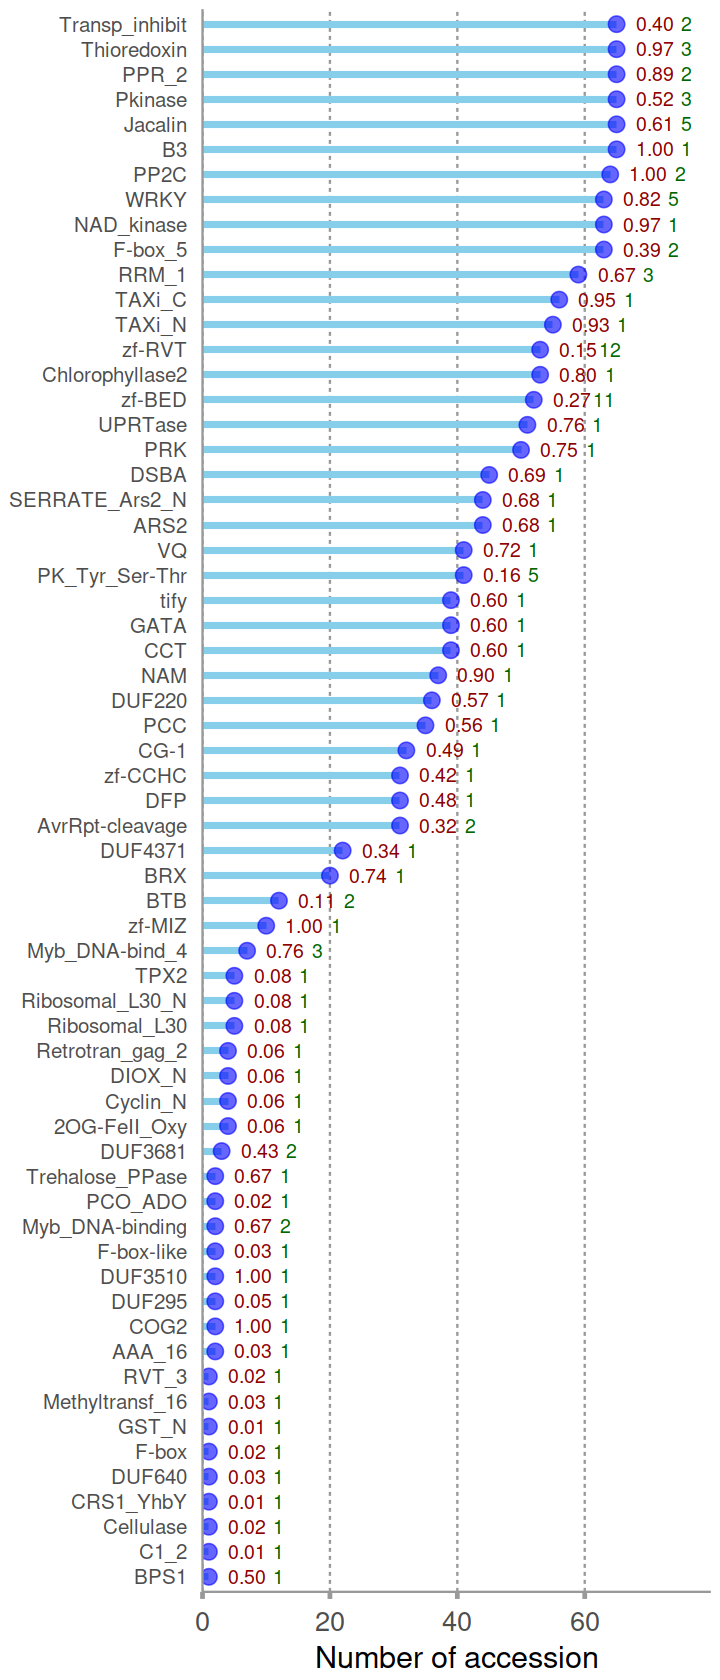

In [61]:
# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major.x = element_line(colour = "gray60", size = 0.5, linetype="dashed"), 
              panel.grid.major.y = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),            
              axis.ticks.length=unit(.15, "cm"), 
              axis.ticks.x = element_line(colour = "gray60", size = 1), 
#               axis.ticks.y = element_line(colour = "gray60", size = 1),
              axis.ticks.y = element_blank(),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=12, color="gray30", 
                                         vjust=0.5, hjust=1,
                                         margin = margin(t = 0, r = 5, b = 0, l = 0)),
#               axis.title.x = element_blank(),
              axis.title.x = element_text(size=18, angle=0, margin = margin(t = 5, r = 0, b = 0, l = 0)),
#               axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.y = element_blank(),
              legend.title = element_blank(),
              legend.position = c(0.85,0.85),
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0
             )
}

options(repr.plot.width = 6, repr.plot.height = 14)
ggplot(data, aes(domain, Assembly_num)) +
    geom_segment( aes(x=domain, xend=domain, y=0, yend=Assembly_num), color="skyblue", size=1.5) +
    geom_point( color="blue", size=4, alpha=0.6) +
    annotate("text",
             x=data[order(data$Assembly_num),]$domain, 
             y=data[order(data$Assembly_num),]$Assembly_num +6,
             label=NLR_ID_ratio,
             size=4,colour="darkred")+
    annotate("text",
             x=data[order(data$Assembly_num),]$domain, 
             y=data[order(data$Assembly_num),]$Assembly_num +11,
             label=data[order(data$Assembly_num),]$HOG_number,
             size=4,colour="darkgreen")+
    scale_y_continuous(limits=c(0,76),expand = expansion(mult = c(0, 0.05))) +
    ylab("Number of accession") +
    theme_custom() +
    coord_flip()

### Figure 6
Sequence diversity and selection pattern across the rice pan-NLRome.

#### A

In [62]:
# create input data
# df are the SumTable imported at begining
# pan-genome section info
df_pan <- df[c('HOG', 'pangenome_section')] %>% unique
# population statistics result
df_pop <- read.csv(paste0(data_path, "all_hog_popGenet_totalNstatus_11Aug2021.csv"),
               header=TRUE,
               stringsAsFactors=FALSE,
               sep=",")

df_pop$nuc.diversity.within.persite_Total <- df_pop$nuc.diversity.within_Total / df_pop$n.sites
df_pop$nuc.diversity.within.persite_Cultivar <- df_pop$nuc.diversity.within_Cultivar / df_pop$n.sites
df_pop$nuc.diversity.within.persite_Landrace <- df_pop$nuc.diversity.within_Landrace / df_pop$n.sites
df_pop$nuc.diversity.within.persite_Wild <- df_pop$nuc.diversity.within_Wild / df_pop$n.sites

col_name <- df_pop %>% colnames()
df_pop1 <- df_pop[c(col_name[19], col_name[9:18], col_name[20:25])]
df_pop2 <- df_pop1 %>% gather(pop_stat, value, 2:17)
df_pop3 <- df_pop2 %>% separate(pop_stat, c("pop_stat", "status"), "_")

input <- merge(df_pop3, df_pan, by='HOG', all.x=TRUE)
input$status <- factor(input$status, levels=c('Total', 'Cultivar', 'Landrace', 'Wild'))
input$pangenome_section <- factor(input$pangenome_section, levels=c('Core', 'Shell', 'Cloud'))

Warning message:
“Removed 243 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 243 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 243 rows containing missing values (geom_point).”


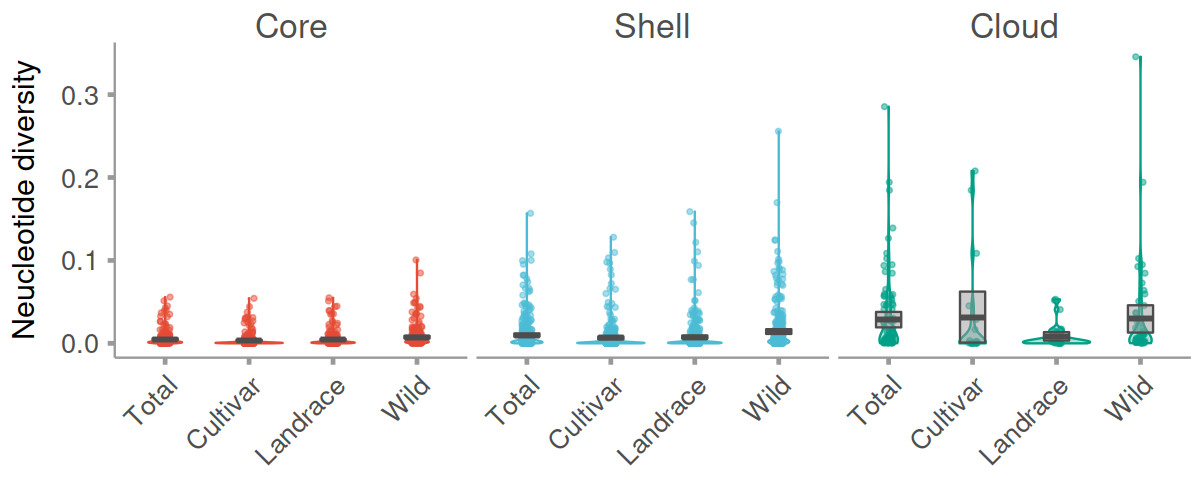

In [63]:
# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "transparent", colour = "transparent", size = rel(2)), 
#               strip.border =  element_blank(),
              strip.text =  element_text(size=20, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 0, r = 0, b = 0, l = 0)),
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=45, color="gray30", vjust=1, hjust=1, margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 15, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.87,0.15),
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0
             )
}

options(repr.plot.width = 10, repr.plot.height = 4)
p <- ggplot(input[(input$pop_stat == 'nuc.diversity.within.persite') & (!is.na(input$pangenome_section)),], 
            aes(status, value, fill=pangenome_section, color=pangenome_section)) +
     geom_violin(alpha=0.3, width=0.8, 
                  position = position_dodge(0.8),
                 show.legend=FALSE) +
     geom_jitter(size=1, 
                 alpha=0.5,
                 position = position_jitterdodge(jitter.width=0.3, dodge.width=0.8),
                 show.legend=FALSE) + 
     stat_summary(geom="crossbar", fun.data=mean_cl_normal, 
                 fun.args=list(conf.int=0.95), fill="grey60", color="grey30", width=0.3, alpha=0.5) +
     facet_grid(cols = vars(pangenome_section), scales="free") +
     ylab("Neucleotide diversity")+
     theme_custom() +
     scale_fill_npg() +
     scale_color_npg() +
     scale_y_continuous(n.breaks=6) 
p

Warning message:
“Removed 243 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 243 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 243 rows containing missing values (geom_point).”


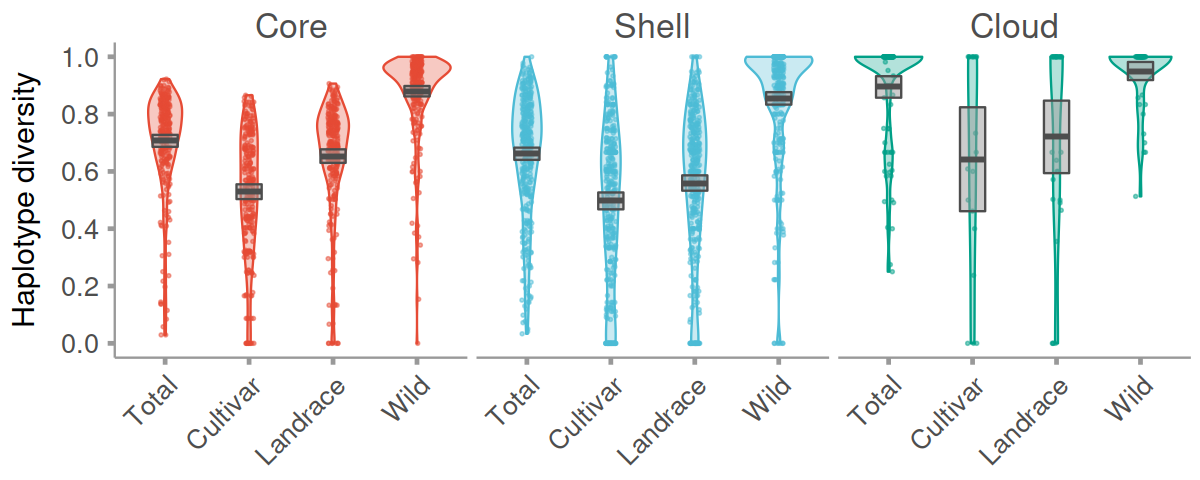

In [64]:
# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "transparent", colour = "transparent", size = rel(2)), 
#               strip.border =  element_blank(),
              strip.text =  element_text(size=20, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 0, r = 0, b = 0, l = 0)),
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=45, color="gray30", vjust=1, hjust=1, margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 15, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.87,0.15),
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0
             )
}

options(repr.plot.width = 10, repr.plot.height = 4)
p <- ggplot(input[(input$pop_stat == 'hap.diversity.within') & (!is.na(input$pangenome_section)),], 
            aes(status, value, fill=pangenome_section, color=pangenome_section)) +
     geom_violin(alpha=0.3, width=0.8, 
                  position = position_dodge(0.8),
                 show.legend=FALSE) +
     geom_jitter(size=0.5, 
                 alpha=0.5,
                 position = position_jitterdodge(jitter.width=0.3, dodge.width=0.8),
                 show.legend=FALSE) + 
     stat_summary(geom="crossbar", fun.data=mean_cl_normal, 
                 fun.args=list(conf.int=0.95), fill="grey60", color="grey30", width=0.3, alpha=0.5) +
     facet_grid(cols = vars(pangenome_section), scales="free") + 
     ylab("Haplotype diversity")+
     theme_custom() +
     scale_fill_npg() +
     scale_color_npg() +
     scale_y_continuous(n.breaks=6) 
p

Warning message:
“Removed 566 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 566 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 566 rows containing missing values (geom_point).”


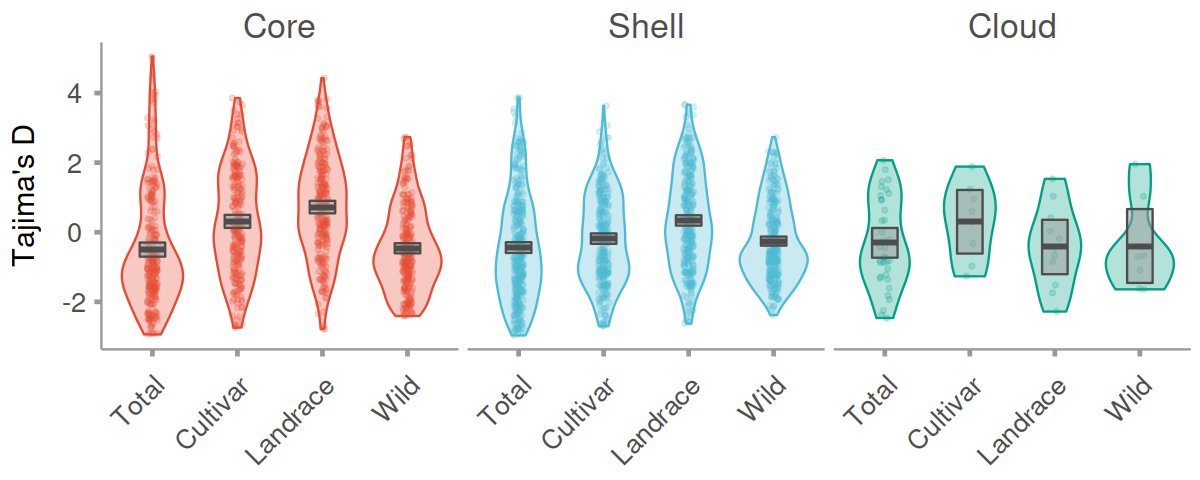

In [65]:
# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks = element_line(colour = "gray60", size = 1),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "transparent", colour = "transparent", size = rel(2)), 
#               strip.border =  element_blank(),
              strip.text =  element_text(size=20, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 0, r = 0, b = 0, l = 0)),
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=45, color="gray30", vjust=1, hjust=1, margin = margin(t = 10, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 15, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.87,0.15),
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0
             )
}

options(repr.plot.width = 10, repr.plot.height = 4)
p <- ggplot(input[(input$pop_stat == 'Tajima.D') & (!is.na(input$pangenome_section)),], 
            aes(status, value, fill=pangenome_section, color=pangenome_section)) +
     geom_violin(alpha=0.3, width=0.8, 
                  position = position_dodge(0.8),
                 show.legend=FALSE) +
     geom_jitter(size=1, 
                 alpha=0.2,
                 position = position_jitterdodge(jitter.width=0.3, dodge.width=0.8),
                 show.legend=FALSE) + 
     stat_summary(geom="crossbar", fun.data=mean_cl_normal, 
                 fun.args=list(conf.int=0.95), fill="grey60", color="grey30", width=0.3, alpha=0.5) +
     facet_grid(cols = vars(pangenome_section), scales="free") +
     ylab("Tajima's D")+
     theme_custom() +
     scale_fill_npg() +
     scale_color_npg() +
     scale_y_continuous(n.breaks=6) 
p

#### B

In [66]:
# IRGSP-build4 genes and predicted_genes position info
b4_rep <- read.table(paste0(data_path,"xpclr_data/all_chr_rep.gff"),
                       quote="", header=F, sep="\t")
b4_pred <- read.table(paste0(data_path,"xpclr_data/all_chr_pred.gff"),
                       quote="", header=F, sep="\t")
b4_anno <- rbind(b4_rep, b4_pred)
b4_gene <- b4_anno %>% subset(V3 %in% c("gene", "predicted_gene"))

b4_gene$build_4 <- b4_gene$V9 %>% 
                    str_split_fixed(";",6) %>% 
                    .[,1] %>% 
                    str_split_fixed("\"",3) %>% 
                    .[,2]

b4_info <- b4_gene[c("build_4", "V1", "V4", "V5")]
colnames(b4_info) <- c("build_4", "chr", "start", "end")

In [67]:
# input all xpclr result together
path <- paste0(data_path,"xpclr_data/xpclr_results/")
flist <- list.files(path, pattern = "out$", recursive = TRUE)
full_flist <- lapply(flist, FUN=function(x) paste0(path, x, collapse="")) %>% unlist()
all_xpclr <- do.call(rbind,
                     lapply(full_flist, FUN=function(x) read.table(x, header=TRUE, sep="\t")))

In [68]:
# generate data for miami plot 
chr_len <- all_xpclr %>% 
    group_by(chrom) %>% 
    summarise(chr_len=max(start))

chr_pos <-  chr_len  %>% 
    mutate(total = cumsum(chr_len) - chr_len) %>%
    select(-chr_len)

snp_pos <- chr_pos %>%
 left_join(all_xpclr, ., by="chrom") %>%
 arrange(chrom, start) %>%
 mutate(start_cum = start + total)

In [69]:
# match domestication and NLR genes with the snp_pos
# domesticated genes
df_dome <- read.table(paste0(data_path,"xpclr_data/known_domesticated_gene.tab"), header=T)
df_dome  <- df_dome %>% merge(b4_info, by.x="gene_ID", by.y="build_4", all.x=TRUE)
df_dome$chr <- df_dome$chr %>% gsub("chr", "", .) %>% as.integer()

result_id <- c()
type_vec <- c()
for (i in 1:length(df_dome$chr)){
    gstart <- df_dome$start[i]
    gend <- df_dome$end[i]
    tmp_df <- snp_pos %>% subset(chrom == df_dome$chr[i], select=c(id, chrom, start, xpclr))
    xstart <- tmp_df$start
    for (y in 1:length(xstart)){
        if (gstart <= xstart[y] && xstart[y] <= gend){
            if (tmp_df$xpclr[y] >= tmp_df$xpclr[y+1]){  # gene cross over the left region: so we choose the region with higher value          
                result_id <- append(result_id, tmp_df$id[y])
                type_vec <- append(type_vec, "inter")
                } else if (tmp_df$xpclr[y] < tmp_df$xpclr[y+1]){
                result_id <- append(result_id, tmp_df$id[y+1])
                type_vec <- append(type_vec, "inter")                
                }
            }else if (xstart[y] <= gstart && gend <= xstart[y+1]){
            result_id <- append(result_id, tmp_df$id[y])
            type_vec <- append(type_vec, "within")          
        }
    }
}
# add xpclr vlaue
df_dome$id <- result_id
df_dome <- df_dome %>% 
            merge(snp_pos[c("id", "start_cum", "xpclr")], by="id", all.x=F)

In [70]:
# match domestication and NLR genes with the snp_pos
# Nipponbare NLRs
df_nlr <- read.table(paste0(data_path,"xpclr_data/02.nlrtracker_out_NLRtracker.tsv"),
                 header=T, fill=T, sep="\t")
colnames(df_nlr) <- c("gene_ID", "status", "subclass", "domain", "NLR_class")
# convert geneID
df_nlr$gene_ID <- df_nlr$gene_ID %>% 
                    str_split_fixed("-",2) %>%
                    .[,1] %>% 
                    gsub("t", "g", .)
df_nlr <- df_nlr %>% 
          subset(grepl("N", NLR_class))
df_nlr$NLR_class_new <- df_nlr$NLR_class %>% 
                        if_else(grepl("O", .), "X-NLR", .) %>% 
                        if_else(. == "CNNL", "CNL", .)
df_nlr <- df_nlr %>% 
            merge(b4_info, by.x="gene_ID", by.y="build_4", all.x=TRUE) %>% 
            subset(!is.na(chr)) %>% 
            distinct(.keep_all = TRUE) # remove duplicated rows as different protein isoforms were identified
df_nlr$chr <- df_nlr$chr %>% gsub("chr", "", .) %>% as.integer()

In [71]:
# sliding window
left_border <- c()
left_xpclr <- c()
right_border <- c()
right_xpclr <- c()
gene_vec <- c()
type_vec <- c()
for (i in 1:length(df_nlr$chr)){
    gstart <- df_nlr$start[i]
    gend <- df_nlr$end[i]
    glen <- gend - gstart +1
    tmp_df <- snp_pos %>% subset(chrom == df_nlr$chr[i], select=c(id, chrom, start, xpclr))
    xstart <- tmp_df$start
        for (y in 1:length(xstart)){
            if (gstart >= xstart[y] && gstart < xstart[y+1]){
                left_border <- append(left_border, tmp_df$id[y])
                left_xpclr <- append(left_xpclr, tmp_df$xpclr[y])
                right_border <- append(right_border, tmp_df$id[y+1])
                right_xpclr <- append(right_xpclr, tmp_df$xpclr[y+1])
                gene_vec <- append(gene_vec, df_nlr$gene_ID[i])
                if (xstart[y+1] - gstart < glen) {
                    type_vec <- append(type_vec, "inter")
                }else {
                    type_vec <- append(type_vec, "within")                    
                }
            } else {NULL}
        }
    }

In [72]:
# make sure which windows to use
tmp <- cbind(gene_ID=gene_vec, start=df_nlr$start, end=df_nlr$end, 
             left_border, left_xpclr, right_border, right_xpclr, type_vec) %>% 
        as.data.frame()
tmp$left_xpclr <- as.numeric(left_xpclr)
tmp$right_xpclr <- as.numeric(right_xpclr)

tmp_within <- subset(tmp, type_vec=="within")
within_id <- tmp_within$left_border

tmp_inter <- subset(tmp, type_vec=="inter")

inter_id <- c()
for (i in 1:length(tmp_inter$gene_ID)){
    if (tmp_inter$left_xpclr[i] <= tmp_inter$right_xpclr[i]){ # taken the samller value as representative
        inter_id <- append(inter_id, tmp_inter$left_border[i])
    } else {
        inter_id <- append(inter_id, tmp_inter$right_border[i])
    }
}

Warning message:
“Removed 844 rows containing missing values (geom_point).”
Warning message:
“Removed 844 rows containing missing values (geom_segment).”


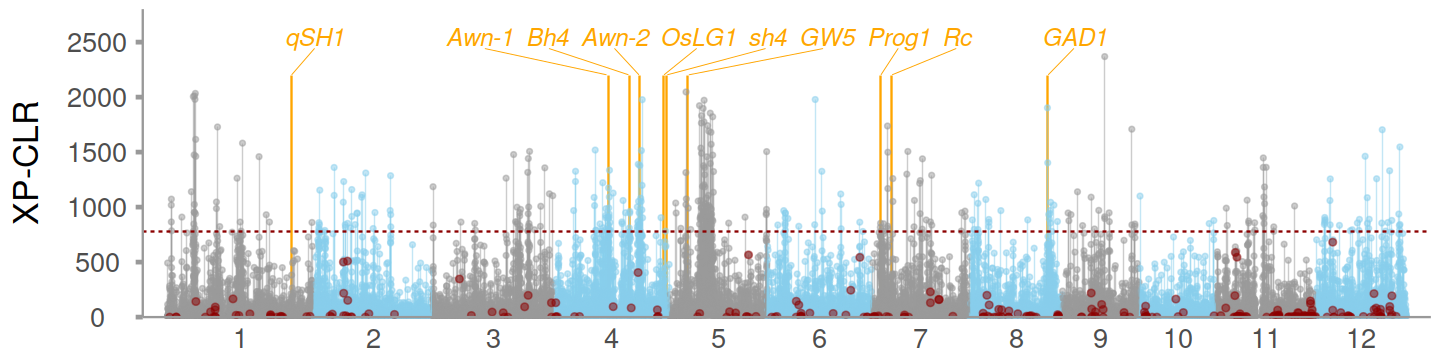

In [73]:
# top 1% signals 
# x axis labels
X_axis <-  snp_pos %>% group_by(chrom) %>% summarize(center=( max(start_cum) + min(start_cum) ) / 2 )
# the xplcr top_n threshold
top_n_xpclr <- snp_pos$xpclr %>% sort(decreasing=T) %>% .[round(length(snp_pos$xpclr)*0.01)]

# plot section
require(ggrepel)
options(repr.plot.width=12, repr.plot.height=3)
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks.y = element_line(colour = "gray60", size = 1),
              axis.ticks.x = element_blank(),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 0, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
              axis.title.x = element_blank(),
              axis.title.y = element_text(size=20, angle=90, margin = margin(t = 0, r = 15, b = 0, l = 0)),
              legend.title = element_blank(),
#               legend.position = c(0.72,0.76),
              legend.position = "right",
              legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0,
              legend.background = element_rect(fill = "transparent", colour = "transparent")
             )
}

p <- ggplot(snp_pos, aes(x=start_cum, y=xpclr)) +
    geom_segment(data=subset(df_dome, type=="Domestication"), aes(x=start_cum, xend=start_cum, y=0, yend=2200), color="orange") +
    geom_text_repel(data=subset(df_dome, type=="Domestication"), 
                    aes(x=start_cum, y=2200, label=gene_name %>% str_split_fixed("/", 2) %>% .[, 1]), 
                        force_pull   = 0, # do not pull toward data points
                        nudge_y      = 350,
                        direction    = "x",
                        angle        = 0,
                        hjust        = 0,
                        segment.size = 0.2,
                        fontface="italic",
                        color="orange", size=5) +
    geom_point(aes(color=as.factor(chrom)), alpha=0.5, size=1, show.legend=F) +
    geom_segment(aes(color=as.factor(chrom), x=start_cum, xend=start_cum, y=0, yend=xpclr), size=0.3, alpha=0.5, show.legend=F) +
#     geom_point(data=subset(df_dome, type=="Domestication"), aes(x=start_cum, y=xpclr), color="red") +
    geom_point(data=subset(snp_pos, id %in% c(within_id, inter_id)), aes(x=start_cum, y=xpclr), color="darkred", alpha=0.5) +
    geom_hline(yintercept = top_n_xpclr, color = "darkred", size = 0.5, linetype = "dashed") +

    scale_color_manual(values = rep(c("grey60", "skyblue"), 12 )) +
    scale_x_continuous(label = X_axis$chrom, breaks= X_axis$center, expand=c(0.02, 0)) +
    scale_y_continuous(limits=c(0, 2800), expand = c(0, 0), n.breaks=6) + 
    ylab("XP-CLR") + 
    theme_custom()
# geom_hline(yintercept = c(6, -log10(0.05/nrow(Snp_pos))), color = c('green', 'red'),size = 1.2, linetype = c("dotted", "twodash")) + 

p 

### Figure 7
Integrated domains and paired NLRs tend to cluster in the phylogeny of the rice pan-NLRome.

In [74]:
# create input data
# df are the SumTable imported at begining
# population statistics result
df_pop <- read.csv(paste0(data_path, "all_hog_popGenet_totalNstatus_11Aug2021.csv"),
               header=TRUE,
               stringsAsFactors=FALSE,
               sep=",")

df_pop$nuc.diversity.within.persite_Total <- df_pop$nuc.diversity.within_Total / df_pop$n.sites
df_pop$nuc.diversity.within.persite_Cultivar <- df_pop$nuc.diversity.within_Cultivar / df_pop$n.sites
df_pop$nuc.diversity.within.persite_Landrace <- df_pop$nuc.diversity.within_Landrace / df_pop$n.sites
df_pop$nuc.diversity.within.persite_Wild <- df_pop$nuc.diversity.within_Wild / df_pop$n.sites

# paired HOG in S1-3 and E1-2 clades
df_hog <- read.csv(paste0(data_path, "paired_HOG.tab"),
               header=TRUE,
               stringsAsFactors=FALSE,
               sep="\t")

# tidy up HOG info
df_hog <- df_hog %>% gather("type", "hog_id", 2:3)
df_hog$HOG <- str_replace(df_hog$hog_id, "HOG_", "N0.HOG0000")

# plot paired HOG info
df_pair_hog_pop <- merge(df_hog, df_pop[c('HOG', 'nuc.diversity.within_Total', 'hap.diversity.within_Total', 'Tajima.D_Total', 'nuc.diversity.within.persite_Total')], by='HOG', all.x=TRUE)

#[2021-9-3] label RGA4/5 Pik1/2 on the regression plots
df_kwn <- read.csv(paste0(data_path, "refPlantNLR_known_NLR.tab"),
               header=TRUE, sep="\t",
               stringsAsFactors=FALSE)

rga4_hog <- df_kwn[df_kwn$Other_ID == "RGA4",]$HOG
rga5_hog <- df_kwn[df_kwn$Other_ID == "RGA5",]$HOG
pik1_hog <- df_kwn[df_kwn$ID == "Pik-1",]$HOG
pik2_hog <- df_kwn[df_kwn$ID == "Pik-2",]$HOG
df_info <- df_pair_hog_pop[df_pair_hog_pop$HOG %in% c(rga4_hog, 
                                                      rga5_hog, 
                                                      pik1_hog, 
                                                      pik2_hog),]

#### C

Warning message:
“Removed 26 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 26 rows containing missing values (geom_point).”


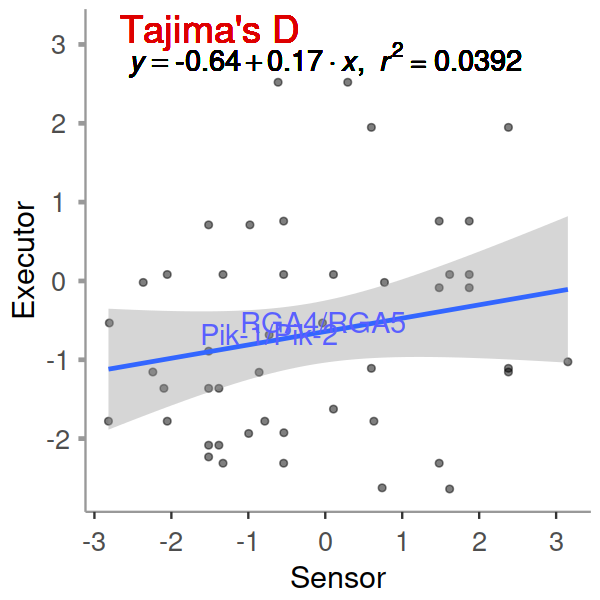

In [75]:
# tidy up input 
tmp_s <- df_pair_hog_pop[df_pair_hog_pop$type == 'Sensor',][c('Pair_No', 'Tajima.D_Total')]
tmp_e <- df_pair_hog_pop[df_pair_hog_pop$type == 'Executor',][c('Pair_No', 'Tajima.D_Total')]

input <- merge(tmp_s, tmp_e, by='Pair_No', all.x=TRUE)
colnames(input) <- c('Pair_No', 'Sensor', 'Executor')

# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks.y = element_line(colour = "gray60", size = 1),
#               axis.ticks = element_blank(),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
#               axis.title.x = element_blank(),
              axis.title.x = element_text(size=18, angle=0, margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 5, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.85,0.85),
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0
             )
}

options(repr.plot.width = 5, repr.plot.height = 5)
# generate coeff-expression of the model
lm_eqn <- function(df){
    m <- lm(y ~ x, df);
    eq <- substitute(italic(y) == a + b %.% italic(x)*","~~italic(r)^2~"="~r2, 
         list(a = format(unname(coef(m)[1]), digits = 2),
              b = format(unname(coef(m)[2]), digits = 2),
             r2 = format(summary(m)$r.squared, digits = 3)))
    as.character(as.expression(eq));
}

coeff_input <- input[c('Sensor', 'Executor')]
colnames(coeff_input) <- c('x', 'y')

t <- ggplot(input, aes(Sensor, Executor)) +
    geom_point(color='black', alpha=0.5) +
    geom_smooth(method='lm',
                formula = y ~ x) + 
    geom_text(x = 0, y = 2.8, label = lm_eqn(coeff_input), parse = TRUE, size=6) +
    geom_text(x = -1.5, y = 3.2, label = "Tajima's D",  size=8, color = '#DC0000B2') +
    theme_custom() +
    xlab("Sensor") +
    ylab("Executor") +
    scale_y_continuous(n.breaks=6) +
    scale_x_continuous(n.breaks=8) +
    annotate("text", 
             x = c(df_info$Tajima.D[1], df_info$Tajima.D[5]), 
             y = c(df_info$Tajima.D[2], df_info$Tajima.D[6]), 
             label = c("RGA4/RGA5", "Pik-1/Pik-2"), 
             color = "#595FFF", size = 6)
t

#### D

Warning message:
“Removed 19 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 19 rows containing missing values (geom_point).”


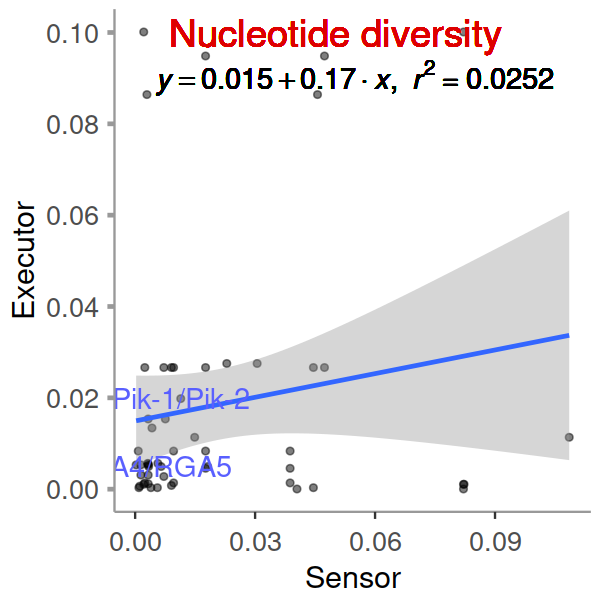

In [76]:
# tidy up input 
tmp_s <- df_pair_hog_pop[df_pair_hog_pop$type == 'Sensor',][c('Pair_No', 'nuc.diversity.within.persite_Total')]
tmp_e <- df_pair_hog_pop[df_pair_hog_pop$type == 'Executor',][c('Pair_No', 'nuc.diversity.within.persite_Total')]

input <- merge(tmp_s, tmp_e, by='Pair_No', all.x=TRUE)
colnames(input) <- c('Pair_No', 'Sensor', 'Executor')

# plot section
theme_custom <- function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_bw(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.border = element_blank(), 
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.line = element_line(colour = "gray60", size = rel(1)),
              axis.ticks.length=unit(.15, "cm"),
              axis.ticks.y = element_line(colour = "gray60", size = 1),
#               axis.ticks = element_blank(),
              legend.key = element_blank(), 
              strip.background = element_rect(fill = "white", colour = "black", size = rel(2)), 
              complete = TRUE,
              axis.text.x = element_text(size=16, angle=0, color="gray30", vjust=0.5, hjust=0.5, margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.text.y = element_text(size=16, color="gray30", margin = margin(t = 0, r = 5, b = 0, l = 0)),
#               axis.title.x = element_blank(),
              axis.title.x = element_text(size=18, angle=0, margin = margin(t = 5, r = 0, b = 0, l = 0)),
              axis.title.y = element_text(size=18, angle=90, margin = margin(t = 0, r = 5, b = 0, l = 0)),
              legend.title = element_blank(),
              legend.position = c(0.85,0.85),
#               legend.position = "bottom",
#               legend.justification = "center",
              legend.text = element_text(size = 14),
              legend.text.align = 0
             )
}

options(repr.plot.width = 5, repr.plot.height = 5)
# generate coeff-expression of the model
lm_eqn <- function(df){
    m <- lm(y ~ x, df);
    eq <- substitute(italic(y) == a + b %.% italic(x)*","~~italic(r)^2~"="~r2, 
         list(a = format(unname(coef(m)[1]), digits = 2),
              b = format(unname(coef(m)[2]), digits = 2),
             r2 = format(summary(m)$r.squared, digits = 3)))
    as.character(as.expression(eq));
}

coeff_input <- input[c('Sensor', 'Executor')]
colnames(coeff_input) <- c('x', 'y')

t <- ggplot(input, aes(Sensor, Executor)) +
    geom_point(color='black', alpha=0.5) +
    geom_smooth(method='lm',
                formula = y ~ x) + 
    geom_text(x = 0.055, y = 0.09, label = lm_eqn(coeff_input), parse = TRUE, size=6) +
    geom_text(x = 0.05, y = 0.1, label = "Nucleotide diversity",  size=8, color = '#DC0000B2') +
    theme_custom() +
    xlab("Sensor") +
    ylab("Executor") +
    scale_y_continuous(n.breaks=7) +
    annotate("text", 
             x = c(df_info$nuc.diversity.within.persite[1], df_info$nuc.diversity.within.persite[5]), 
             y = c(df_info$nuc.diversity.within.persite[2], df_info$nuc.diversity.within.persite[6]), 
             label = c("RGA4/RGA5", "Pik-1/Pik-2"), 
             color = "#595FFF", size = 6)
t